<a href="https://colab.research.google.com/github/joaonfcastro/Data_Science_Trading_Esportivo/blob/main/Data_Science_Trading_Esportivo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Data Science aplicado ao Trading Esportivo**

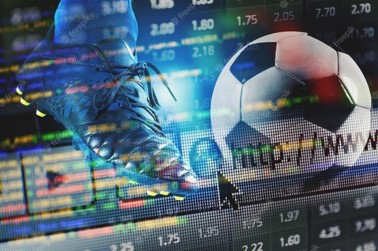

O **Trading Esportivo** é um tipo de mercado especulativo voltado para a bolsa esportiva de apostas. Neste mercado é possível realizar operações a favor ou contra a probabilidade de um evento em uma partida esportiva, respectivamente conhecidas como **Back** ou **Lay**.

Este projeto buscou aplicar nesse mercado tecnicas e ferramentas de Data Science com o objetivo de realizar um pipeline que percorra a coleta, preparação e transformação dos dados, para correta aplicação de **Modelos Supervisionados de Machine Learnig** na tentativa de prever resultados futuros das partidas.

#### **Load Libraries**

Vamos carregar o dataset com as estatisticas dos ultimos 10 anos das 7 principais ligas nacionais europeias. Os dados foram extraídos do portal https://www.football-data.co.uk/ e posteriomente passados em um processo de data prep para ajustes e seleção das principais features.

Ligas:
* Premier League
* Budesliga
* La Liga
* Calcio
* Ligue 1
* Eredivise
* Liga de Portugal

In [304]:
#Libraries Default EDA
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
from google.colab import files
import warnings
import datetime as dt
from scipy import constants
import plotly.express as px
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
warnings.filterwarnings('ignore', category=FutureWarning)
from google.colab import drive
drive.mount('/content/drive')


#Libraries Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### **Import Dataset**

In [305]:
#Import Dataset hist de 10 years
df = pd.read_excel('/content/df_football_hist_10_years.xlsx')
df.head()

,Unnamed: 0,Match,League,Season,Date,Home,Away,HomeGoals,AwayGoals,Result,HomeShootsTarget,AwayShootsTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellow,AwayYellow,HomeRed,AwayRed,HomeOdds,DrawOdds,AwayOdds
0,0,1,Liga Portugal,23-24,2023-09-09,Moreirense,Sp Braga,2,3,A,3,5,12,11,4,5,2,2,0,0,4.20,3.75,1.80
1,1,2,Calcio,23-24,2023-09-03,Lecce,Salernitana,2,0,H,6,4,17,15,6,5,3,3,0,0,2.00,3.30,4.00
2,2,3,Bundesliga,23-24,2023-09-03,Union Berlin,RB Leipzig,0,3,A,1,8,16,9,3,7,3,1,1,0,3.40,3.25,2.20
3,3,4,La Liga,23-24,2023-09-03,Girona,Las Palmas,1,0,H,6,5,15,10,3,5,3,3,0,0,1.67,3.80,5.25
4,4,5,Eredivisie,23-24,2023-09-03,Utrecht,Feyenoord,1,5,A,1,11,13,13,5,8,1,0,0,0,4.75,4.50,1.62


#### **Exploratory Data Analysis**

In [306]:
#Show number rows and columns of dataset
df.shape

(20159, 23)

In [307]:
#Show infos and data types of Dataet
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20159 entries, 0 to 20158
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Unnamed: 0        20159 non-null  int64         
 1   Match             20159 non-null  int64         
 2   League            20159 non-null  object        
 3   Season            20159 non-null  object        
 4   Date              20159 non-null  datetime64[ns]
 5   Home              20159 non-null  object        
 6   Away              20159 non-null  object        
 7   HomeGoals         20159 non-null  int64         
 8   AwayGoals         20159 non-null  int64         
 9   Result            20159 non-null  object        
 10  HomeShootsTarget  20159 non-null  int64         
 11  AwayShootsTarget  20159 non-null  int64         
 12  HomeFouls         20159 non-null  int64         
 13  AwayFouls         20159 non-null  int64         
 14  HomeCorners       2015

In [308]:
#Show missing values
df.isnull().sum()

Unnamed: 0          0
Match               0
League              0
Season              0
Date                0
Home                0
Away                0
HomeGoals           0
AwayGoals           0
Result              0
HomeShootsTarget    0
AwayShootsTarget    0
HomeFouls           0
AwayFouls           0
HomeCorners         0
AwayCorners         0
HomeYellow          0
AwayYellow          0
HomeRed             0
AwayRed             0
HomeOdds            0
DrawOdds            0
AwayOdds            0
dtype: int64

In [309]:
#Drop columns
df = df.drop(['Unnamed: 0'], axis=1)

In [310]:
print("Esse dataset contem estatisticas de", df.Match.nunique(), 'partidas', "referente as ultimas", df.Season.nunique(), 'temporadas')

Esse dataset contem estatisticas de 20159 partidas referente as ultimas 10 temporadas


##### Data Viz - Initials Insights

In [311]:
#Top 10 Times com Mais Vitorias como Mandante
df_viz = df[df['Result'] == "H"].groupby(['Home']).agg({'Match':'count'}).nlargest(10, 'Match').reset_index()
fig = px.bar(df_viz,
             x='Home',
             y='Match',
             text_auto=True,
             height=400,
             width=800,
             template='seaborn',
             labels={'Match':"Wins", 'Home':'Team'})
fig.update_layout(title={"text":"Top 10 Times com Mais Vitorias como Mandante", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

In [312]:
#Top 10 Times com Mais Vitorias como visitante
df_viz = df[df['Result'] == "A"].groupby(['Away']).agg({'Match':'count'}).nlargest(10, 'Match').reset_index()
fig = px.bar(df_viz,
             x='Away',
             y='Match',
             text_auto=True,
             height=400,
             width=800,
             template='seaborn',
             labels={'Match':"Wins", 'Away':'Team'})
fig.update_layout(title={"text":"Top 10 Times com Mais Vitorias como visitante", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

In [313]:
#Top 10 Times com Melhor Media de Gols por Partida como Mandante
df_viz = df.groupby(['Home']).agg({'HomeGoals': 'mean'}).nlargest(10, "HomeGoals").reset_index()
fig = px.bar(df_viz,
             x='Home',
             y='HomeGoals',
             text_auto='.1f',
             height=400,
             width=800,
             template='seaborn',
             labels={'HomeGoals':"Media de Gols", 'Home':'Team'})
fig.update_layout(title={"text":"Top 10 Times com Melhor Media de Gols por Partida como Mandante", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

In [314]:
#Top 10 Times com Melhor Media de Gols por Partida como Visitante
df_viz = df.groupby(['Away']).agg({'AwayGoals': 'mean'}).nlargest(10, "AwayGoals").reset_index()
fig = px.bar(df_viz,
             x='Away',
             y='AwayGoals',
             text_auto='.1f',
             height=400,
             width=800,
             template='seaborn',
             labels={'AwayGoals':"Media de Goals", 'Away':'eam'})
fig.update_layout(title={"text":"Top 10 Times com Melhor Media de Gols por Partida como Visitante", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

In [315]:
#Top 10 Times com Maior Media de Faltas por Partida como Mandante
df_viz = df.groupby(['Home']).agg({'HomeFouls': 'mean'}).nlargest(10, "HomeFouls").reset_index()
fig = px.bar(df_viz,
             x='Home',
             y='HomeFouls',
             text_auto='.1f',
             height=400,
             width=800,
             template='seaborn',
             labels={'HomeFouls':"Media de Faltas", 'Home':'Team'})
fig.update_layout(title={"text":"Top 10 Times com Maior Media de Faltas por Partida como Mandante", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

In [316]:
#Top 10 Times com Maior Media de Faltas por Partida como Visitante
df_viz = df.groupby(['Away']).agg({'AwayFouls': 'mean'}).nlargest(10, "AwayFouls").reset_index()
fig = px.bar(df_viz,
             x='Away',
             y='AwayFouls',
             text_auto='.1f',
             height=400,
             width=800,
             template='seaborn',
             labels={'AwayFouls':"Media de Faltas", 'Away':'Team'})
fig.update_layout(title={"text":"Top 10 Times com Maior Media de Faltas por Partida como Visitante", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

In [317]:
#Top 10 Times com Maior Media de Escanteios por Partida como Mandante
df_viz = df.groupby(['Home']).agg({'HomeCorners': 'mean'}).nlargest(10, "HomeCorners").reset_index()
fig = px.bar(df_viz,
             x='Home',
             y='HomeCorners',
             text_auto='.1f',
             height=400,
             width=800,
             template='seaborn',
             labels={'HomeCorners':"Media de Escanteios", 'Home':'Team'})
fig.update_layout(title={"text":"Top 10 Times com Maior Media de Escanteios por Partida como Mandante", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

In [318]:
#Top 10 Times com Maior Media de Escanteios por Partida como Visitante
df_viz = df.groupby(['Away']).agg({'AwayCorners': 'mean'}).nlargest(10, "AwayCorners").reset_index()
fig = px.bar(df_viz,
             x='Away',
             y='AwayCorners',
             text_auto='.1f',
             height=400,
             width=800,
             template='seaborn',
             labels={'AwayCorners':"Media de Escanteios", 'Away':'Team'})
fig.update_layout(title={"text":"Top 10 Times com Maior Media de Escanteios por Partida como Visitante", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

In [319]:
#Top 10 Times com Maior Media de Cartoes Amarelos por Partida como Mandante
df_viz = df.groupby(['Home']).agg({'HomeYellow': 'mean'}).nlargest(10, "HomeYellow").reset_index()
fig = px.bar(df_viz,
             x='Home',
             y='HomeYellow',
             text_auto='.1f',
             height=400,
             width=800,
             template='seaborn',
             labels={'HomeYellow':"Media de Cartoes Amarelos", 'Home':'Team'})
fig.update_layout(title={"text":"Top 10 Times com Maior Media de Cartoes Amarelos por Partida como Mandante", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

In [320]:
#Top 10 Times com Maior Media de Cartoes Amarelos por Partida como Visitante
df_viz = df.groupby(['Away']).agg({'AwayYellow': 'mean'}).nlargest(10, "AwayYellow").reset_index()
fig = px.bar(df_viz,
             x='Away',
             y='AwayYellow',
             text_auto='.1f',
             height=400,
             width=800,
             template='seaborn',
             labels={'AwayYellow':"Media de Cartoes Amarelos", 'Away':'Team'})
fig.update_layout(title={"text":"Top 10 Times com Maior Media de Cartoes Amarelos por Partida como Visitante", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

In [321]:
#Top 10 Times com Maior Media de Cartoes Vermelhos por Partida como Mandante
df_viz = df.groupby(['Home']).agg({'HomeRed': 'mean'}).nlargest(10, "HomeRed").reset_index()
fig = px.bar(df_viz,
             x='Home',
             y='HomeRed',
             text_auto='.1f',
             height=400,
             width=800,
             template='seaborn',
             labels={'HomeRed':"Media de Cartoes Vermelhos", 'Home':'Team'})
fig.update_layout(title={"text":"Top 10 Times com Maior Media de Cartoes Vermelhos por Partida como Mandante", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

In [322]:
#Top 10 Times com Maior Media de Cartoes Vermelhos por Partida como Visitante
df_viz = df.groupby(['Away']).agg({'AwayRed': 'mean'}).nlargest(10, "AwayRed").reset_index()
fig = px.bar(df_viz,
             x='Away',
             y='AwayRed',
             text_auto='.1f',
             height=400,
             width=800,
             template='seaborn',
             labels={'AwayRed':"Media de Cartoes Vermelhos", 'Away':'Team'})
fig.update_layout(title={"text":"Top 10 Times com Maior Media de Cartoes Vermelhos por Partida como Visitante", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

#### **Feature Engineering**

No processo de **Feature engineering** vamos aplicar tecnicas de manipulação e transformação nas **features existentes (primarias)** para extrair o máximo potencial dos dados e criação de **novas features (secundarias)**.Essa etapa é também conhecida como pré-processamento de dados. Essa é uma das fases mais importantes do processo de construção de um modelo preditivo, considerando que são as features o "combustível" que move qualquer processo de aprendizado de máquina.

##### **Create Columns Result per Match Individual**

In [323]:
#Create Columns Result per Match Individual
df['HomeResult'] = np.where(df.Result == 'H', 1, 0)
df['DrawResult'] = np.where(df.Result == 'D', 1, 0)
df['AwayResult'] = np.where(df.Result == 'A', 1, 0)

#Show dataset
df.head()

,Match,League,Season,Date,Home,Away,HomeGoals,AwayGoals,Result,HomeShootsTarget,AwayShootsTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellow,AwayYellow,HomeRed,AwayRed,HomeOdds,DrawOdds,AwayOdds,HomeResult,DrawResult,AwayResult
0,1,Liga Portugal,23-24,2023-09-09,Moreirense,Sp Braga,2,3,A,3,5,12,11,4,5,2,2,0,0,4.20,3.75,1.80,0,0,1
1,2,Calcio,23-24,2023-09-03,Lecce,Salernitana,2,0,H,6,4,17,15,6,5,3,3,0,0,2.00,3.30,4.00,1,0,0
2,3,Bundesliga,23-24,2023-09-03,Union Berlin,RB Leipzig,0,3,A,1,8,16,9,3,7,3,1,1,0,3.40,3.25,2.20,0,0,1
3,4,La Liga,23-24,2023-09-03,Girona,Las Palmas,1,0,H,6,5,15,10,3,5,3,3,0,0,1.67,3.80,5.25,1,0,0
4,5,Eredivisie,23-24,2023-09-03,Utrecht,Feyenoord,1,5,A,1,11,13,13,5,8,1,0,0,0,4.75,4.50,1.62,0,0,1


##### **Create Columns Back and Lay Linear**

In [324]:
#Create columns Back Linear
Win_Back_Home = 1 * df.HomeOdds - 1
Win_Back_Draw = 1 * df.DrawOdds - 1
Win_Back_Away = 1 * df.AwayOdds - 1
lose = -1

df['Back_Home'] = Win_Back_Home.where(df.Result == 'H', lose).round(2)
df['Back_Draw'] = Win_Back_Home.where(df.Result == 'D', lose).round(2)
df['Back_Away'] = Win_Back_Home.where(df.Result == 'A', lose).round(2)

In [325]:
#Create columns Back acumulado
df['Back_Home_Acu'] = df.Back_Home.cumsum().round(2)
df['Back_Draw_Acu'] = df.Back_Draw.cumsum().round(2)
df['Back_Away_Acu'] = df.Back_Away.cumsum().round(2)

In [326]:
#Create columns Lay Linear
Win_Lay_Home = 1 / (df.HomeOdds - 0.99)
Win_Lay_Draw = 1 / (df.DrawOdds - 0.99)
Win_Lay_Away = 1 / (df.AwayOdds - 0.99)
lose = -1

df['Lay_Home'] = Win_Lay_Home.where(df.Result != 'H', lose).round(2)
df['Lay_Draw'] = Win_Lay_Draw.where(df.Result != 'D', lose).round(2)
df['Lay_Away'] = Win_Lay_Away.where(df.Result != 'A', lose).round(2)

In [327]:
#Create columns Lay acumulado
df['Lay_Home_Acu'] = df.Lay_Home.cumsum().round(2)
df['Lay_Draw_Acu'] = df.Lay_Draw.cumsum().round(2)
df['Lay_Away_Acu'] = df.Lay_Away.cumsum().round(2)

In [328]:
#Show dataset
df.head()

,Match,League,Season,Date,Home,Away,HomeGoals,AwayGoals,Result,HomeShootsTarget,AwayShootsTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellow,AwayYellow,HomeRed,AwayRed,HomeOdds,DrawOdds,AwayOdds,HomeResult,DrawResult,AwayResult,Back_Home,Back_Draw,Back_Away,Back_Home_Acu,Back_Draw_Acu,Back_Away_Acu,Lay_Home,Lay_Draw,Lay_Away,Lay_Home_Acu,Lay_Draw_Acu,Lay_Away_Acu
0,1,Liga Portugal,23-24,2023-09-09,Moreirense,Sp Braga,2,3,A,3,5,12,11,4,5,2,2,0,0,4.20,3.75,1.80,0,0,1,-1.00,-1.0,3.20,-1.00,-1.0,3.20,0.31,0.36,-1.00,0.31,0.36,-1.00
1,2,Calcio,23-24,2023-09-03,Lecce,Salernitana,2,0,H,6,4,17,15,6,5,3,3,0,0,2.00,3.30,4.00,1,0,0,1.00,-1.0,-1.00,0.00,-2.0,2.20,-1.00,0.43,0.33,-0.69,0.79,-0.67
2,3,Bundesliga,23-24,2023-09-03,Union Berlin,RB Leipzig,0,3,A,1,8,16,9,3,7,3,1,1,0,3.40,3.25,2.20,0,0,1,-1.00,-1.0,2.40,-1.00,-3.0,4.60,0.41,0.44,-1.00,-0.28,1.23,-1.67
3,4,La Liga,23-24,2023-09-03,Girona,Las Palmas,1,0,H,6,5,15,10,3,5,3,3,0,0,1.67,3.80,5.25,1,0,0,0.67,-1.0,-1.00,-0.33,-4.0,3.60,-1.00,0.36,0.23,-1.28,1.59,-1.44
4,5,Eredivisie,23-24,2023-09-03,Utrecht,Feyenoord,1,5,A,1,11,13,13,5,8,1,0,0,0,4.75,4.50,1.62,0,0,1,-1.00,-1.0,3.75,-1.33,-5.0,7.35,0.27,0.28,-1.00,-1.01,1.87,-2.44


##### **Proba Odds - Create Columns based in Odds Abs**

In [329]:
#Create columns Proba Odds
df['Proba(Home)'] = round(df.apply(lambda row: (1/ row['HomeOdds']), axis=1), 2)
df['Proba(Draw)'] = round(df.apply(lambda row: (1/ row['DrawOdds']), axis=1), 2)
df['Proba(Away)'] = round(df.apply(lambda row: (1/ row['AwayOdds']), axis=1), 2)

#Show dataset
df.head()

,Match,League,Season,Date,Home,Away,HomeGoals,AwayGoals,Result,HomeShootsTarget,AwayShootsTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellow,AwayYellow,HomeRed,AwayRed,HomeOdds,DrawOdds,AwayOdds,HomeResult,DrawResult,AwayResult,Back_Home,Back_Draw,Back_Away,Back_Home_Acu,Back_Draw_Acu,Back_Away_Acu,Lay_Home,Lay_Draw,Lay_Away,Lay_Home_Acu,Lay_Draw_Acu,Lay_Away_Acu,Proba(Home),Proba(Draw),Proba(Away)
0,1,Liga Portugal,23-24,2023-09-09,Moreirense,Sp Braga,2,3,A,3,5,12,11,4,5,2,2,0,0,4.20,3.75,1.80,0,0,1,-1.00,-1.0,3.20,-1.00,-1.0,3.20,0.31,0.36,-1.00,0.31,0.36,-1.00,0.24,0.27,0.56
1,2,Calcio,23-24,2023-09-03,Lecce,Salernitana,2,0,H,6,4,17,15,6,5,3,3,0,0,2.00,3.30,4.00,1,0,0,1.00,-1.0,-1.00,0.00,-2.0,2.20,-1.00,0.43,0.33,-0.69,0.79,-0.67,0.50,0.30,0.25
2,3,Bundesliga,23-24,2023-09-03,Union Berlin,RB Leipzig,0,3,A,1,8,16,9,3,7,3,1,1,0,3.40,3.25,2.20,0,0,1,-1.00,-1.0,2.40,-1.00,-3.0,4.60,0.41,0.44,-1.00,-0.28,1.23,-1.67,0.29,0.31,0.45
3,4,La Liga,23-24,2023-09-03,Girona,Las Palmas,1,0,H,6,5,15,10,3,5,3,3,0,0,1.67,3.80,5.25,1,0,0,0.67,-1.0,-1.00,-0.33,-4.0,3.60,-1.00,0.36,0.23,-1.28,1.59,-1.44,0.60,0.26,0.19
4,5,Eredivisie,23-24,2023-09-03,Utrecht,Feyenoord,1,5,A,1,11,13,13,5,8,1,0,0,0,4.75,4.50,1.62,0,0,1,-1.00,-1.0,3.75,-1.33,-5.0,7.35,0.27,0.28,-1.00,-1.01,1.87,-2.44,0.21,0.22,0.62


##### **Create Columns Points**

In [330]:
#Create Columns Points
def Home_Points (Result):
  if Result == 'H':
    Points = 3
  elif Result =='D':
    Points = 1
  else:
    Points = 0
  return Points

def Away_Points (Result):
  if Result == 'A':
    Points = 3
  elif Result =='D':
    Points = 1
  else:
    Points = 0
  return Points

df['Home_Points'] = df.apply(lambda row: Home_Points(row['Result']), axis=1)
df['Away_Points'] = df.apply(lambda row: Away_Points(row['Result']), axis=1)

#Show dataset
df.head()

,Match,League,Season,Date,Home,Away,HomeGoals,AwayGoals,Result,HomeShootsTarget,AwayShootsTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellow,AwayYellow,HomeRed,AwayRed,HomeOdds,DrawOdds,AwayOdds,HomeResult,DrawResult,AwayResult,Back_Home,Back_Draw,Back_Away,Back_Home_Acu,Back_Draw_Acu,Back_Away_Acu,Lay_Home,Lay_Draw,Lay_Away,Lay_Home_Acu,Lay_Draw_Acu,Lay_Away_Acu,Proba(Home),Proba(Draw),Proba(Away),Home_Points,Away_Points
0,1,Liga Portugal,23-24,2023-09-09,Moreirense,Sp Braga,2,3,A,3,5,12,11,4,5,2,2,0,0,4.20,3.75,1.80,0,0,1,-1.00,-1.0,3.20,-1.00,-1.0,3.20,0.31,0.36,-1.00,0.31,0.36,-1.00,0.24,0.27,0.56,0,3
1,2,Calcio,23-24,2023-09-03,Lecce,Salernitana,2,0,H,6,4,17,15,6,5,3,3,0,0,2.00,3.30,4.00,1,0,0,1.00,-1.0,-1.00,0.00,-2.0,2.20,-1.00,0.43,0.33,-0.69,0.79,-0.67,0.50,0.30,0.25,3,0
2,3,Bundesliga,23-24,2023-09-03,Union Berlin,RB Leipzig,0,3,A,1,8,16,9,3,7,3,1,1,0,3.40,3.25,2.20,0,0,1,-1.00,-1.0,2.40,-1.00,-3.0,4.60,0.41,0.44,-1.00,-0.28,1.23,-1.67,0.29,0.31,0.45,0,3
3,4,La Liga,23-24,2023-09-03,Girona,Las Palmas,1,0,H,6,5,15,10,3,5,3,3,0,0,1.67,3.80,5.25,1,0,0,0.67,-1.0,-1.00,-0.33,-4.0,3.60,-1.00,0.36,0.23,-1.28,1.59,-1.44,0.60,0.26,0.19,3,0
4,5,Eredivisie,23-24,2023-09-03,Utrecht,Feyenoord,1,5,A,1,11,13,13,5,8,1,0,0,0,4.75,4.50,1.62,0,0,1,-1.00,-1.0,3.75,-1.33,-5.0,7.35,0.27,0.28,-1.00,-1.01,1.87,-2.44,0.21,0.22,0.62,0,3


##### **Create Columns Total Goals**

In [331]:
#Create column total goals
df['TotalGoals'] = df.apply(lambda row: (row['HomeGoals'] + row['AwayGoals']), axis=1)

#Show dataset
df.head()

,Match,League,Season,Date,Home,Away,HomeGoals,AwayGoals,Result,HomeShootsTarget,AwayShootsTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellow,AwayYellow,HomeRed,AwayRed,HomeOdds,DrawOdds,AwayOdds,HomeResult,DrawResult,AwayResult,Back_Home,Back_Draw,Back_Away,Back_Home_Acu,Back_Draw_Acu,Back_Away_Acu,Lay_Home,Lay_Draw,Lay_Away,Lay_Home_Acu,Lay_Draw_Acu,Lay_Away_Acu,Proba(Home),Proba(Draw),Proba(Away),Home_Points,Away_Points,TotalGoals
0,1,Liga Portugal,23-24,2023-09-09,Moreirense,Sp Braga,2,3,A,3,5,12,11,4,5,2,2,0,0,4.20,3.75,1.80,0,0,1,-1.00,-1.0,3.20,-1.00,-1.0,3.20,0.31,0.36,-1.00,0.31,0.36,-1.00,0.24,0.27,0.56,0,3,5
1,2,Calcio,23-24,2023-09-03,Lecce,Salernitana,2,0,H,6,4,17,15,6,5,3,3,0,0,2.00,3.30,4.00,1,0,0,1.00,-1.0,-1.00,0.00,-2.0,2.20,-1.00,0.43,0.33,-0.69,0.79,-0.67,0.50,0.30,0.25,3,0,2
2,3,Bundesliga,23-24,2023-09-03,Union Berlin,RB Leipzig,0,3,A,1,8,16,9,3,7,3,1,1,0,3.40,3.25,2.20,0,0,1,-1.00,-1.0,2.40,-1.00,-3.0,4.60,0.41,0.44,-1.00,-0.28,1.23,-1.67,0.29,0.31,0.45,0,3,3
3,4,La Liga,23-24,2023-09-03,Girona,Las Palmas,1,0,H,6,5,15,10,3,5,3,3,0,0,1.67,3.80,5.25,1,0,0,0.67,-1.0,-1.00,-0.33,-4.0,3.60,-1.00,0.36,0.23,-1.28,1.59,-1.44,0.60,0.26,0.19,3,0,1
4,5,Eredivisie,23-24,2023-09-03,Utrecht,Feyenoord,1,5,A,1,11,13,13,5,8,1,0,0,0,4.75,4.50,1.62,0,0,1,-1.00,-1.0,3.75,-1.33,-5.0,7.35,0.27,0.28,-1.00,-1.01,1.87,-2.44,0.21,0.22,0.62,0,3,6


##### **Create Columns Total Cards**

In [332]:
#Yellow Cards
df['TotalCardsYellow'] = df.apply(lambda row: (row['HomeYellow'] + row['AwayYellow']), axis=1)

#Show dataset
df.head()

,Match,League,Season,Date,Home,Away,HomeGoals,AwayGoals,Result,HomeShootsTarget,AwayShootsTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellow,AwayYellow,HomeRed,AwayRed,HomeOdds,DrawOdds,AwayOdds,HomeResult,DrawResult,AwayResult,Back_Home,Back_Draw,Back_Away,Back_Home_Acu,Back_Draw_Acu,Back_Away_Acu,Lay_Home,Lay_Draw,Lay_Away,Lay_Home_Acu,Lay_Draw_Acu,Lay_Away_Acu,Proba(Home),Proba(Draw),Proba(Away),Home_Points,Away_Points,TotalGoals,TotalCardsYellow
0,1,Liga Portugal,23-24,2023-09-09,Moreirense,Sp Braga,2,3,A,3,5,12,11,4,5,2,2,0,0,4.20,3.75,1.80,0,0,1,-1.00,-1.0,3.20,-1.00,-1.0,3.20,0.31,0.36,-1.00,0.31,0.36,-1.00,0.24,0.27,0.56,0,3,5,4
1,2,Calcio,23-24,2023-09-03,Lecce,Salernitana,2,0,H,6,4,17,15,6,5,3,3,0,0,2.00,3.30,4.00,1,0,0,1.00,-1.0,-1.00,0.00,-2.0,2.20,-1.00,0.43,0.33,-0.69,0.79,-0.67,0.50,0.30,0.25,3,0,2,6
2,3,Bundesliga,23-24,2023-09-03,Union Berlin,RB Leipzig,0,3,A,1,8,16,9,3,7,3,1,1,0,3.40,3.25,2.20,0,0,1,-1.00,-1.0,2.40,-1.00,-3.0,4.60,0.41,0.44,-1.00,-0.28,1.23,-1.67,0.29,0.31,0.45,0,3,3,4
3,4,La Liga,23-24,2023-09-03,Girona,Las Palmas,1,0,H,6,5,15,10,3,5,3,3,0,0,1.67,3.80,5.25,1,0,0,0.67,-1.0,-1.00,-0.33,-4.0,3.60,-1.00,0.36,0.23,-1.28,1.59,-1.44,0.60,0.26,0.19,3,0,1,6
4,5,Eredivisie,23-24,2023-09-03,Utrecht,Feyenoord,1,5,A,1,11,13,13,5,8,1,0,0,0,4.75,4.50,1.62,0,0,1,-1.00,-1.0,3.75,-1.33,-5.0,7.35,0.27,0.28,-1.00,-1.01,1.87,-2.44,0.21,0.22,0.62,0,3,6,1


In [333]:
#Red Cards
df['TotalCardsRed'] = df.apply(lambda row: (row['HomeRed'] + row['AwayRed']), axis=1)
df.head()

,Match,League,Season,Date,Home,Away,HomeGoals,AwayGoals,Result,HomeShootsTarget,AwayShootsTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellow,AwayYellow,HomeRed,AwayRed,HomeOdds,DrawOdds,AwayOdds,HomeResult,DrawResult,AwayResult,Back_Home,Back_Draw,Back_Away,Back_Home_Acu,Back_Draw_Acu,Back_Away_Acu,Lay_Home,Lay_Draw,Lay_Away,Lay_Home_Acu,Lay_Draw_Acu,Lay_Away_Acu,Proba(Home),Proba(Draw),Proba(Away),Home_Points,Away_Points,TotalGoals,TotalCardsYellow,TotalCardsRed
0,1,Liga Portugal,23-24,2023-09-09,Moreirense,Sp Braga,2,3,A,3,5,12,11,4,5,2,2,0,0,4.20,3.75,1.80,0,0,1,-1.00,-1.0,3.20,-1.00,-1.0,3.20,0.31,0.36,-1.00,0.31,0.36,-1.00,0.24,0.27,0.56,0,3,5,4,0
1,2,Calcio,23-24,2023-09-03,Lecce,Salernitana,2,0,H,6,4,17,15,6,5,3,3,0,0,2.00,3.30,4.00,1,0,0,1.00,-1.0,-1.00,0.00,-2.0,2.20,-1.00,0.43,0.33,-0.69,0.79,-0.67,0.50,0.30,0.25,3,0,2,6,0
2,3,Bundesliga,23-24,2023-09-03,Union Berlin,RB Leipzig,0,3,A,1,8,16,9,3,7,3,1,1,0,3.40,3.25,2.20,0,0,1,-1.00,-1.0,2.40,-1.00,-3.0,4.60,0.41,0.44,-1.00,-0.28,1.23,-1.67,0.29,0.31,0.45,0,3,3,4,1
3,4,La Liga,23-24,2023-09-03,Girona,Las Palmas,1,0,H,6,5,15,10,3,5,3,3,0,0,1.67,3.80,5.25,1,0,0,0.67,-1.0,-1.00,-0.33,-4.0,3.60,-1.00,0.36,0.23,-1.28,1.59,-1.44,0.60,0.26,0.19,3,0,1,6,0
4,5,Eredivisie,23-24,2023-09-03,Utrecht,Feyenoord,1,5,A,1,11,13,13,5,8,1,0,0,0,4.75,4.50,1.62,0,0,1,-1.00,-1.0,3.75,-1.33,-5.0,7.35,0.27,0.28,-1.00,-1.01,1.87,-2.44,0.21,0.22,0.62,0,3,6,1,0


##### **Create Columns Total Shoots on Target**

In [334]:
#Create Total Shoots on Target
df['TotalShootsTarget'] = df.apply(lambda row: (row['HomeShootsTarget'] + row['AwayShootsTarget']), axis=1)

#Show dataset
df.head()

,Match,League,Season,Date,Home,Away,HomeGoals,AwayGoals,Result,HomeShootsTarget,AwayShootsTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellow,AwayYellow,HomeRed,AwayRed,HomeOdds,DrawOdds,AwayOdds,HomeResult,DrawResult,AwayResult,Back_Home,Back_Draw,Back_Away,Back_Home_Acu,Back_Draw_Acu,Back_Away_Acu,Lay_Home,Lay_Draw,Lay_Away,Lay_Home_Acu,Lay_Draw_Acu,Lay_Away_Acu,Proba(Home),Proba(Draw),Proba(Away),Home_Points,Away_Points,TotalGoals,TotalCardsYellow,TotalCardsRed,TotalShootsTarget
0,1,Liga Portugal,23-24,2023-09-09,Moreirense,Sp Braga,2,3,A,3,5,12,11,4,5,2,2,0,0,4.20,3.75,1.80,0,0,1,-1.00,-1.0,3.20,-1.00,-1.0,3.20,0.31,0.36,-1.00,0.31,0.36,-1.00,0.24,0.27,0.56,0,3,5,4,0,8
1,2,Calcio,23-24,2023-09-03,Lecce,Salernitana,2,0,H,6,4,17,15,6,5,3,3,0,0,2.00,3.30,4.00,1,0,0,1.00,-1.0,-1.00,0.00,-2.0,2.20,-1.00,0.43,0.33,-0.69,0.79,-0.67,0.50,0.30,0.25,3,0,2,6,0,10
2,3,Bundesliga,23-24,2023-09-03,Union Berlin,RB Leipzig,0,3,A,1,8,16,9,3,7,3,1,1,0,3.40,3.25,2.20,0,0,1,-1.00,-1.0,2.40,-1.00,-3.0,4.60,0.41,0.44,-1.00,-0.28,1.23,-1.67,0.29,0.31,0.45,0,3,3,4,1,9
3,4,La Liga,23-24,2023-09-03,Girona,Las Palmas,1,0,H,6,5,15,10,3,5,3,3,0,0,1.67,3.80,5.25,1,0,0,0.67,-1.0,-1.00,-0.33,-4.0,3.60,-1.00,0.36,0.23,-1.28,1.59,-1.44,0.60,0.26,0.19,3,0,1,6,0,11
4,5,Eredivisie,23-24,2023-09-03,Utrecht,Feyenoord,1,5,A,1,11,13,13,5,8,1,0,0,0,4.75,4.50,1.62,0,0,1,-1.00,-1.0,3.75,-1.33,-5.0,7.35,0.27,0.28,-1.00,-1.01,1.87,-2.44,0.21,0.22,0.62,0,3,6,1,0,12


##### **Create Columns Total Fouls**

In [335]:
#Create Total Fouls
df['TotalFouls'] = df.apply(lambda row: (row['HomeFouls'] + row['AwayFouls']), axis=1)

#Show dataset
df.head()

,Match,League,Season,Date,Home,Away,HomeGoals,AwayGoals,Result,HomeShootsTarget,AwayShootsTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellow,AwayYellow,HomeRed,AwayRed,HomeOdds,DrawOdds,AwayOdds,HomeResult,DrawResult,AwayResult,Back_Home,Back_Draw,Back_Away,Back_Home_Acu,Back_Draw_Acu,Back_Away_Acu,Lay_Home,Lay_Draw,Lay_Away,Lay_Home_Acu,Lay_Draw_Acu,Lay_Away_Acu,Proba(Home),Proba(Draw),Proba(Away),Home_Points,Away_Points,TotalGoals,TotalCardsYellow,TotalCardsRed,TotalShootsTarget,TotalFouls
0,1,Liga Portugal,23-24,2023-09-09,Moreirense,Sp Braga,2,3,A,3,5,12,11,4,5,2,2,0,0,4.20,3.75,1.80,0,0,1,-1.00,-1.0,3.20,-1.00,-1.0,3.20,0.31,0.36,-1.00,0.31,0.36,-1.00,0.24,0.27,0.56,0,3,5,4,0,8,23
1,2,Calcio,23-24,2023-09-03,Lecce,Salernitana,2,0,H,6,4,17,15,6,5,3,3,0,0,2.00,3.30,4.00,1,0,0,1.00,-1.0,-1.00,0.00,-2.0,2.20,-1.00,0.43,0.33,-0.69,0.79,-0.67,0.50,0.30,0.25,3,0,2,6,0,10,32
2,3,Bundesliga,23-24,2023-09-03,Union Berlin,RB Leipzig,0,3,A,1,8,16,9,3,7,3,1,1,0,3.40,3.25,2.20,0,0,1,-1.00,-1.0,2.40,-1.00,-3.0,4.60,0.41,0.44,-1.00,-0.28,1.23,-1.67,0.29,0.31,0.45,0,3,3,4,1,9,25
3,4,La Liga,23-24,2023-09-03,Girona,Las Palmas,1,0,H,6,5,15,10,3,5,3,3,0,0,1.67,3.80,5.25,1,0,0,0.67,-1.0,-1.00,-0.33,-4.0,3.60,-1.00,0.36,0.23,-1.28,1.59,-1.44,0.60,0.26,0.19,3,0,1,6,0,11,25
4,5,Eredivisie,23-24,2023-09-03,Utrecht,Feyenoord,1,5,A,1,11,13,13,5,8,1,0,0,0,4.75,4.50,1.62,0,0,1,-1.00,-1.0,3.75,-1.33,-5.0,7.35,0.27,0.28,-1.00,-1.01,1.87,-2.44,0.21,0.22,0.62,0,3,6,1,0,12,26


##### **Create Columns Total Offsides**

In [336]:
#Create Total Offsides
# df['TotalOffsides'] = df.apply(lambda row: (row['HomeOffsides'] + row['AwayOffsides']), axis=1)

#Show dataset
# df.head()

##### **Create Columns Total Corners**

In [337]:
#Create Columns Total corners
df['TotalCorners'] = df.apply(lambda row: (row['HomeCorners'] + row['AwayCorners']), axis=1)

#Show dataset
df.head()

,Match,League,Season,Date,Home,Away,HomeGoals,AwayGoals,Result,HomeShootsTarget,AwayShootsTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellow,AwayYellow,HomeRed,AwayRed,HomeOdds,DrawOdds,AwayOdds,HomeResult,DrawResult,AwayResult,Back_Home,Back_Draw,Back_Away,Back_Home_Acu,Back_Draw_Acu,Back_Away_Acu,Lay_Home,Lay_Draw,Lay_Away,Lay_Home_Acu,Lay_Draw_Acu,Lay_Away_Acu,Proba(Home),Proba(Draw),Proba(Away),Home_Points,Away_Points,TotalGoals,TotalCardsYellow,TotalCardsRed,TotalShootsTarget,TotalFouls,TotalCorners
0,1,Liga Portugal,23-24,2023-09-09,Moreirense,Sp Braga,2,3,A,3,5,12,11,4,5,2,2,0,0,4.20,3.75,1.80,0,0,1,-1.00,-1.0,3.20,-1.00,-1.0,3.20,0.31,0.36,-1.00,0.31,0.36,-1.00,0.24,0.27,0.56,0,3,5,4,0,8,23,9
1,2,Calcio,23-24,2023-09-03,Lecce,Salernitana,2,0,H,6,4,17,15,6,5,3,3,0,0,2.00,3.30,4.00,1,0,0,1.00,-1.0,-1.00,0.00,-2.0,2.20,-1.00,0.43,0.33,-0.69,0.79,-0.67,0.50,0.30,0.25,3,0,2,6,0,10,32,11
2,3,Bundesliga,23-24,2023-09-03,Union Berlin,RB Leipzig,0,3,A,1,8,16,9,3,7,3,1,1,0,3.40,3.25,2.20,0,0,1,-1.00,-1.0,2.40,-1.00,-3.0,4.60,0.41,0.44,-1.00,-0.28,1.23,-1.67,0.29,0.31,0.45,0,3,3,4,1,9,25,10
3,4,La Liga,23-24,2023-09-03,Girona,Las Palmas,1,0,H,6,5,15,10,3,5,3,3,0,0,1.67,3.80,5.25,1,0,0,0.67,-1.0,-1.00,-0.33,-4.0,3.60,-1.00,0.36,0.23,-1.28,1.59,-1.44,0.60,0.26,0.19,3,0,1,6,0,11,25,8
4,5,Eredivisie,23-24,2023-09-03,Utrecht,Feyenoord,1,5,A,1,11,13,13,5,8,1,0,0,0,4.75,4.50,1.62,0,0,1,-1.00,-1.0,3.75,-1.33,-5.0,7.35,0.27,0.28,-1.00,-1.01,1.87,-2.44,0.21,0.22,0.62,0,3,6,1,0,12,26,13


##### **Over Goals - Create Columns Mean Over Goals**

In [338]:
#Create columns Over
df['Over_05_Goals'] = df.apply(lambda row: 1 if (row['TotalGoals'] >= 1) else 0, axis=1)
df['Over_15_Goals'] = df.apply(lambda row: 1 if (row['TotalGoals'] > 1) else 0, axis=1)
df['Over_25_Goals'] = df.apply(lambda row: 1 if (row['TotalGoals'] > 2) else 0, axis=1)
df['Over_35_Goals'] = df.apply(lambda row: 1 if (row['TotalGoals'] > 3) else 0, axis=1)
df['BTTS'] = df.apply(lambda row: 1 if (row['HomeGoals'] > 0 and row['AwayGoals'] > 0) else 0, axis=1)

#Show dataset
df.head()

,Match,League,Season,Date,Home,Away,HomeGoals,AwayGoals,Result,HomeShootsTarget,AwayShootsTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellow,AwayYellow,HomeRed,AwayRed,HomeOdds,DrawOdds,AwayOdds,HomeResult,DrawResult,AwayResult,Back_Home,Back_Draw,Back_Away,Back_Home_Acu,Back_Draw_Acu,Back_Away_Acu,Lay_Home,Lay_Draw,Lay_Away,Lay_Home_Acu,Lay_Draw_Acu,Lay_Away_Acu,Proba(Home),Proba(Draw),Proba(Away),Home_Points,Away_Points,TotalGoals,TotalCardsYellow,TotalCardsRed,TotalShootsTarget,TotalFouls,TotalCorners,Over_05_Goals,Over_15_Goals,Over_25_Goals,Over_35_Goals,BTTS
0,1,Liga Portugal,23-24,2023-09-09,Moreirense,Sp Braga,2,3,A,3,5,12,11,4,5,2,2,0,0,4.20,3.75,1.80,0,0,1,-1.00,-1.0,3.20,-1.00,-1.0,3.20,0.31,0.36,-1.00,0.31,0.36,-1.00,0.24,0.27,0.56,0,3,5,4,0,8,23,9,1,1,1,1,1
1,2,Calcio,23-24,2023-09-03,Lecce,Salernitana,2,0,H,6,4,17,15,6,5,3,3,0,0,2.00,3.30,4.00,1,0,0,1.00,-1.0,-1.00,0.00,-2.0,2.20,-1.00,0.43,0.33,-0.69,0.79,-0.67,0.50,0.30,0.25,3,0,2,6,0,10,32,11,1,1,0,0,0
2,3,Bundesliga,23-24,2023-09-03,Union Berlin,RB Leipzig,0,3,A,1,8,16,9,3,7,3,1,1,0,3.40,3.25,2.20,0,0,1,-1.00,-1.0,2.40,-1.00,-3.0,4.60,0.41,0.44,-1.00,-0.28,1.23,-1.67,0.29,0.31,0.45,0,3,3,4,1,9,25,10,1,1,1,0,0
3,4,La Liga,23-24,2023-09-03,Girona,Las Palmas,1,0,H,6,5,15,10,3,5,3,3,0,0,1.67,3.80,5.25,1,0,0,0.67,-1.0,-1.00,-0.33,-4.0,3.60,-1.00,0.36,0.23,-1.28,1.59,-1.44,0.60,0.26,0.19,3,0,1,6,0,11,25,8,1,0,0,0,0
4,5,Eredivisie,23-24,2023-09-03,Utrecht,Feyenoord,1,5,A,1,11,13,13,5,8,1,0,0,0,4.75,4.50,1.62,0,0,1,-1.00,-1.0,3.75,-1.33,-5.0,7.35,0.27,0.28,-1.00,-1.01,1.87,-2.44,0.21,0.22,0.62,0,3,6,1,0,12,26,13,1,1,1,1,1


In [339]:
#Mean Home
mean_over_05_goals_Home = df[['League', 'Home', 'Over_05_Goals']].groupby(['League','Home']).mean().round(2)
mean_over_15_goals_Home = df[['League','Home', 'Over_15_Goals']].groupby(['League','Home']).mean().round(2)
mean_over_25_goals_Home = df[['League','Home', 'Over_25_Goals']].groupby(['League','Home']).mean().round(2)
mean_over_35_goals_Home = df[['League','Home', 'Over_35_Goals']].groupby(['League','Home']).mean().round(2)
mean_btts_goals_Home = df[['League','Home', 'BTTS']].groupby(['League','Home']).mean().round(2)

#Concat Datasets
df_mean_goals_Home = pd.concat([mean_over_05_goals_Home, mean_over_15_goals_Home, mean_over_25_goals_Home, mean_over_35_goals_Home, mean_btts_goals_Home], axis=1)

#Show dataset
df_mean_goals_Home.head()

Over_05_Goals  Over_15_Goals  Over_25_Goals  \
League     Home                                                         
Bundesliga Augsburg                0.94           0.82           0.59   
           Bayern Munich           0.99           0.92           0.73   
           Bielefeld               0.91           0.65           0.35   
           Bochum                  0.94           0.83           0.49   
           Darmstadt               0.91           0.80           0.51   

                          Over_35_Goals  BTTS  
League     Home                                
Bundesliga Augsburg                0.37  0.62  
           Bayern Munich           0.56  0.52  
           Bielefeld               0.18  0.44  
           Bochum                  0.26  0.51  
           Darmstadt               0.26  0.49

In [340]:
#Rename columns
df_mean_goals_Home.columns = ['Over_05_Goals_Home', 'Over_15_Goals_Home', 'Over_25_Goals_Home', 'Over_35_Goals_Home', 'BTTS_Home']

#Show dataset
df_mean_goals_Home.head()

Over_05_Goals_Home  Over_15_Goals_Home  \
League     Home                                                    
Bundesliga Augsburg                     0.94                0.82   
           Bayern Munich                0.99                0.92   
           Bielefeld                    0.91                0.65   
           Bochum                       0.94                0.83   
           Darmstadt                    0.91                0.80   

                          Over_25_Goals_Home  Over_35_Goals_Home  BTTS_Home  
League     Home                                                              
Bundesliga Augsburg                     0.59                0.37       0.62  
           Bayern Munich                0.73                0.56       0.52  
           Bielefeld                    0.35                0.18       0.44  
           Bochum                       0.49                0.26       0.51  
           Darmstadt                    0.51                0.26       0.49

In [341]:
#Mean Away
mean_over_05_goals_Away = df[['League', 'Away', 'Over_05_Goals']].groupby(['League','Away']).mean().round(2)
mean_over_15_goals_Away = df[['League','Away', 'Over_15_Goals']].groupby(['League','Away']).mean().round(2)
mean_over_25_goals_Away = df[['League','Away', 'Over_25_Goals']].groupby(['League','Away']).mean().round(2)
mean_over_35_goals_Away = df[['League','Away', 'Over_35_Goals']].groupby(['League','Away']).mean().round(2)
mean_btts_goals_Away = df[['League','Away', 'BTTS']].groupby(['League', 'Away']).mean().round(2)

#Concat Datasets
df_mean_goals_Away = pd.concat([mean_over_05_goals_Away, mean_over_15_goals_Away, mean_over_25_goals_Away, mean_over_35_goals_Away, mean_btts_goals_Away], axis=1)

#Show dataset
df_mean_goals_Away.head()

Over_05_Goals  Over_15_Goals  Over_25_Goals  \
League     Away                                                         
Bundesliga Augsburg                0.91           0.74           0.51   
           Bayern Munich           0.95           0.82           0.65   
           Bielefeld               0.91           0.74           0.44   
           Bochum                  1.00           0.83           0.58   
           Darmstadt               0.97           0.78           0.50   

                          Over_35_Goals  BTTS  
League     Away                                
Bundesliga Augsburg                0.32  0.53  
           Bayern Munich           0.45  0.55  
           Bielefeld               0.26  0.38  
           Bochum                  0.33  0.47  
           Darmstadt               0.36  0.50

In [342]:
#Rename columns
df_mean_goals_Away.columns = ['Over_05_Goals_Away', 'Over_15_Goals_Away', 'Over_25_Goals_Away', 'Over_35_Goals_Away', 'BTTS_Away']

#Show dataset
df_mean_goals_Away.head()

Over_05_Goals_Away  Over_15_Goals_Away  \
League     Away                                                    
Bundesliga Augsburg                     0.91                0.74   
           Bayern Munich                0.95                0.82   
           Bielefeld                    0.91                0.74   
           Bochum                       1.00                0.83   
           Darmstadt                    0.97                0.78   

                          Over_25_Goals_Away  Over_35_Goals_Away  BTTS_Away  
League     Away                                                              
Bundesliga Augsburg                     0.51                0.32       0.53  
           Bayern Munich                0.65                0.45       0.55  
           Bielefeld                    0.44                0.26       0.38  
           Bochum                       0.58                0.33       0.47  
           Darmstadt                    0.50                0.36       0.50

##### **Over Corners - Create Columns Mean Over Corners**

In [343]:
#Create columns Over
df['Over_5_Corners'] = df.apply(lambda row: 1 if (row['TotalCorners'] > 5) else 0, axis=1)
df['Over_6_Corners'] = df.apply(lambda row: 1 if (row['TotalCorners'] > 6) else 0, axis=1)
df['Over_7_Corners'] = df.apply(lambda row: 1 if (row['TotalCorners'] > 7) else 0, axis=1)
df['Over_8_Corners'] = df.apply(lambda row: 1 if (row['TotalCorners'] > 8) else 0, axis=1)
df['Over_9_Corners'] = df.apply(lambda row: 1 if (row['TotalCorners'] > 9) else 0, axis=1)
df['Over_10_Corners'] = df.apply(lambda row: 1 if (row['TotalCorners'] > 10) else 0, axis=1)
df['Over_11_Corners'] = df.apply(lambda row: 1 if (row['TotalCorners'] > 11) else 0, axis=1)
df['Over_12_Corners'] = df.apply(lambda row: 1 if (row['TotalCorners'] > 12) else 0, axis=1)

#Show dataset
df.head()

,Match,League,Season,Date,Home,Away,HomeGoals,AwayGoals,Result,HomeShootsTarget,AwayShootsTarget,HomeFouls,AwayFouls,HomeCorners,AwayCorners,HomeYellow,AwayYellow,HomeRed,AwayRed,HomeOdds,DrawOdds,AwayOdds,HomeResult,DrawResult,AwayResult,Back_Home,Back_Draw,Back_Away,Back_Home_Acu,Back_Draw_Acu,Back_Away_Acu,Lay_Home,Lay_Draw,Lay_Away,Lay_Home_Acu,Lay_Draw_Acu,Lay_Away_Acu,Proba(Home),Proba(Draw),Proba(Away),Home_Points,Away_Points,TotalGoals,TotalCardsYellow,TotalCardsRed,TotalShootsTarget,TotalFouls,TotalCorners,Over_05_Goals,Over_15_Goals,Over_25_Goals,Over_35_Goals,BTTS,Over_5_Corners,Over_6_Corners,Over_7_Corners,Over_8_Corners,Over_9_Corners,Over_10_Corners,Over_11_Corners,Over_12_Corners
0,1,Liga Portugal,23-24,2023-09-09,Moreirense,Sp Braga,2,3,A,3,5,12,11,4,5,2,2,0,0,4.20,3.75,1.80,0,0,1,-1.00,-1.0,3.20,-1.00,-1.0,3.20,0.31,0.36,-1.00,0.31,0.36,-1.00,0.24,0.27,0.56,0,3,5,4,0,8,23,9,1,1,1,1,1,1,1,1,1,0,0,0,0
1,2,Calcio,23-24,2023-09-03,Lecce,Salernitana,2,0,H,6,4,17,15,6,5,3,3,0,0,2.00,3.30,4.00,1,0,0,1.00,-1.0,-1.00,0.00,-2.0,2.20,-1.00,0.43,0.33,-0.69,0.79,-0.67,0.50,0.30,0.25,3,0,2,6,0,10,32,11,1,1,0,0,0,1,1,1,1,1,1,0,0
2,3,Bundesliga,23-24,2023-09-03,Union Berlin,RB Leipzig,0,3,A,1,8,16,9,3,7,3,1,1,0,3.40,3.25,2.20,0,0,1,-1.00,-1.0,2.40,-1.00,-3.0,4.60,0.41,0.44,-1.00,-0.28,1.23,-1.67,0.29,0.31,0.45,0,3,3,4,1,9,25,10,1,1,1,0,0,1,1,1,1,1,0,0,0
3,4,La Liga,23-24,2023-09-03,Girona,Las Palmas,1,0,H,6,5,15,10,3,5,3,3,0,0,1.67,3.80,5.25,1,0,0,0.67,-1.0,-1.00,-0.33,-4.0,3.60,-1.00,0.36,0.23,-1.28,1.59,-1.44,0.60,0.26,0.19,3,0,1,6,0,11,25,8,1,0,0,0,0,1,1,1,0,0,0,0,0
4,5,Eredivisie,23-24,2023-09-03,Utrecht,Feyenoord,1,5,A,1,11,13,13,5,8,1,0,0,0,4.75,4.50,1.62,0,0,1,-1.00,-1.0,3.75,-1.33,-5.0,7.35,0.27,0.28,-1.00,-1.01,1.87,-2.44,0.21,0.22,0.62,0,3,6,1,0,12,26,13,1,1,1,1,1,1,1,1,1,1,1,1,1


In [344]:
#Mean Home
mean_over_5_corners_Home = df[['League', 'Home', 'Over_5_Corners']].groupby(['League','Home']).mean().round(2)
mean_over_6_corners_Home = df[['League', 'Home', 'Over_6_Corners']].groupby(['League','Home']).mean().round(2)
mean_over_7_corners_Home = df[['League', 'Home', 'Over_7_Corners']].groupby(['League','Home']).mean().round(2)
mean_over_8_corners_Home = df[['League', 'Home', 'Over_8_Corners']].groupby(['League','Home']).mean().round(2)
mean_over_9_corners_Home = df[['League', 'Home', 'Over_9_Corners']].groupby(['League','Home']).mean().round(2)
mean_over_10_corners_Home = df[['League', 'Home', 'Over_10_Corners']].groupby(['League','Home']).mean().round(2)
mean_over_11_corners_Home = df[['League', 'Home', 'Over_11_Corners']].groupby(['League','Home']).mean().round(2)
mean_over_12_corners_Home = df[['League', 'Home', 'Over_12_Corners']].groupby(['League','Home']).mean().round(2)

#Concat Datasets
df_mean_corners_Home = pd.concat([mean_over_5_corners_Home, mean_over_6_corners_Home, mean_over_7_corners_Home, mean_over_8_corners_Home, mean_over_9_corners_Home, mean_over_10_corners_Home,
                                mean_over_11_corners_Home, mean_over_12_corners_Home], axis=1)

#Show dataset
df_mean_corners_Home.head()

Over_5_Corners  Over_6_Corners  Over_7_Corners  \
League     Home                                                            
Bundesliga Augsburg                 0.86            0.77            0.66   
           Bayern Munich            0.91            0.84            0.79   
           Bielefeld                0.94            0.82            0.79   
           Bochum                   0.94            0.83            0.77   
           Darmstadt                0.83            0.71            0.66   

                          Over_8_Corners  Over_9_Corners  Over_10_Corners  \
League     Home                                                             
Bundesliga Augsburg                 0.52            0.46             0.32   
           Bayern Munich            0.71            0.58             0.46   
           Bielefeld                0.50            0.41             0.35   
           Bochum                   0.69            0.49             0.34   
           Darmstadt                0.51            0.43             0.34   

                          Over_11_Corners  Over_12_Corners  
League     Home                                             
Bundesliga Augsburg                  0.23             0.16  
           Bayern Munich             0.36             0.21  
           Bielefeld                 0.21             0.15  
           Bochum                    0.26             0.20  
           Darmstadt                 0.20             0.14

In [345]:
#Rename columns
df_mean_corners_Home.columns = ['Over_5_Corners_Home', 'Over_6_Corners_Home', 'Over_7_Corners_Home', 'Over_8_Corners_Home', 'Over_9_Corners_Home', 'Over_10_Corners_Home',
                                'Over_11_Corners_Home', 'Over_12_Corners_Home']

#Show dataset
df_mean_corners_Home.head()

Over_5_Corners_Home  Over_6_Corners_Home  \
League     Home                                                      
Bundesliga Augsburg                      0.86                 0.77   
           Bayern Munich                 0.91                 0.84   
           Bielefeld                     0.94                 0.82   
           Bochum                        0.94                 0.83   
           Darmstadt                     0.83                 0.71   

                          Over_7_Corners_Home  Over_8_Corners_Home  \
League     Home                                                      
Bundesliga Augsburg                      0.66                 0.52   
           Bayern Munich                 0.79                 0.71   
           Bielefeld                     0.79                 0.50   
           Bochum                        0.77                 0.69   
           Darmstadt                     0.66                 0.51   

                          Over_9_Corners_Home  Over_10_Corners_Home  \
League     Home                                                       
Bundesliga Augsburg                      0.46                  0.32   
           Bayern Munich                 0.58                  0.46   
           Bielefeld                     0.41                  0.35   
           Bochum                        0.49                  0.34   
           Darmstadt                     0.43                  0.34   

                          Over_11_Corners_Home  Over_12_Corners_Home  
League     Home                                                       
Bundesliga Augsburg                       0.23                  0.16  
           Bayern Munich                  0.36                  0.21  
           Bielefeld                      0.21                  0.15  
           Bochum                         0.26                  0.20  
           Darmstadt                      0.20                  0.14

In [346]:
#Mean Away
mean_over_5_corners_Away = df[['League', 'Away', 'Over_5_Corners']].groupby(['League','Away']).mean().round(2)
mean_over_6_corners_Away = df[['League', 'Away', 'Over_6_Corners']].groupby(['League','Away']).mean().round(2)
mean_over_7_corners_Away = df[['League', 'Away', 'Over_7_Corners']].groupby(['League','Away']).mean().round(2)
mean_over_8_corners_Away = df[['League', 'Away', 'Over_8_Corners']].groupby(['League','Away']).mean().round(2)
mean_over_9_corners_Away = df[['League', 'Away', 'Over_9_Corners']].groupby(['League','Away']).mean().round(2)
mean_over_10_corners_Away = df[['League', 'Away', 'Over_10_Corners']].groupby(['League','Away']).mean().round(2)
mean_over_11_corners_Away = df[['League', 'Away', 'Over_11_Corners']].groupby(['League','Away']).mean().round(2)
mean_over_12_corners_Away = df[['League', 'Away', 'Over_12_Corners']].groupby(['League','Away']).mean().round(2)

#Concat Datasets
df_mean_corners_Away = pd.concat([mean_over_5_corners_Away, mean_over_6_corners_Away, mean_over_7_corners_Away, mean_over_8_corners_Away, mean_over_9_corners_Away, mean_over_10_corners_Away,
                                mean_over_11_corners_Away, mean_over_12_corners_Away], axis=1)

#Show dataset
df_mean_corners_Away.head()

Over_5_Corners  Over_6_Corners  Over_7_Corners  \
League     Away                                                            
Bundesliga Augsburg                 0.90            0.82            0.75   
           Bayern Munich            0.89            0.83            0.72   
           Bielefeld                0.85            0.82            0.62   
           Bochum                   0.86            0.81            0.61   
           Darmstadt                0.97            0.81            0.78   

                          Over_8_Corners  Over_9_Corners  Over_10_Corners  \
League     Away                                                             
Bundesliga Augsburg                 0.61            0.47             0.34   
           Bayern Munich            0.60            0.50             0.37   
           Bielefeld                0.53            0.38             0.32   
           Bochum                   0.53            0.44             0.33   
           Darmstadt                0.69            0.61             0.44   

                          Over_11_Corners  Over_12_Corners  
League     Away                                             
Bundesliga Augsburg                  0.23             0.16  
           Bayern Munich             0.26             0.16  
           Bielefeld                 0.26             0.24  
           Bochum                    0.22             0.17  
           Darmstadt                 0.31             0.25

In [347]:
#Rename columns
df_mean_corners_Away.columns = ['Over_5_Corners_Away', 'Over_6_Corners_Away', 'Over_7_Corners_Away', 'Over_8_Corners_Away', 'Over_9_Corners_Away', 'Over_10_Corners_Away',
                                'Over_11_Corners_Away', 'Over_12_Corners_Away']

#Show dataset
df_mean_corners_Away.head()

Over_5_Corners_Away  Over_6_Corners_Away  \
League     Away                                                      
Bundesliga Augsburg                      0.90                 0.82   
           Bayern Munich                 0.89                 0.83   
           Bielefeld                     0.85                 0.82   
           Bochum                        0.86                 0.81   
           Darmstadt                     0.97                 0.81   

                          Over_7_Corners_Away  Over_8_Corners_Away  \
League     Away                                                      
Bundesliga Augsburg                      0.75                 0.61   
           Bayern Munich                 0.72                 0.60   
           Bielefeld                     0.62                 0.53   
           Bochum                        0.61                 0.53   
           Darmstadt                     0.78                 0.69   

                          Over_9_Corners_Away  Over_10_Corners_Away  \
League     Away                                                       
Bundesliga Augsburg                      0.47                  0.34   
           Bayern Munich                 0.50                  0.37   
           Bielefeld                     0.38                  0.32   
           Bochum                        0.44                  0.33   
           Darmstadt                     0.61                  0.44   

                          Over_11_Corners_Away  Over_12_Corners_Away  
League     Away                                                       
Bundesliga Augsburg                       0.23                  0.16  
           Bayern Munich                  0.26                  0.16  
           Bielefeld                      0.26                  0.24  
           Bochum                         0.22                  0.17  
           Darmstadt                      0.31                  0.25

##### **Shoots - Create Columns Total, Mean Goals, Standard Deviation and Coefficient of variation**

In [348]:
#Create Columns
tt_shootstarget_Home = df[['League', 'Home', 'HomeShootsTarget']].groupby(['League','Home']).sum().round(2)
mean_shootstarget_Home = df[['League', 'Home', 'HomeShootsTarget']].groupby(['League','Home']).mean().round(2)
tt_shootstarget_Away = df[['League', 'Away', 'AwayShootsTarget']].groupby(['League','Away']).sum().round(2)
mean_shootstarget_Away = df[['League','Away', 'AwayShootsTarget']].groupby(['League','Away']).mean().round(2)
std_shootstarget_Home = df[['League','Home', 'HomeShootsTarget']].groupby(['League','Home']).std().round(2)
std_shootstarget_Away = df[['League','Away', 'AwayShootsTarget']].groupby(['League','Away']).std().round(2)
cv_shootstarget_Home = (std_shootstarget_Home / mean_shootstarget_Home).round(2)
cv_shootstarget_Away = (std_shootstarget_Away / mean_shootstarget_Away).round(2)

#Concat datasets
df_shootstarget = pd.concat([tt_shootstarget_Home, mean_shootstarget_Home, tt_shootstarget_Away, mean_shootstarget_Away, std_shootstarget_Home, std_shootstarget_Away, cv_shootstarget_Home, cv_shootstarget_Away], axis=1)

#Show dataset
df_shootstarget.head()

HomeShootsTarget  HomeShootsTarget  \
League                                                         
Bundesliga Augsburg                    682              4.40   
           Bayern Munich              1279              8.31   
           Bielefeld                   119              3.50   
           Bochum                      176              5.03   
           Darmstadt                   112              3.20   

                          AwayShootsTarget  AwayShootsTarget  \
League                                                         
Bundesliga Augsburg                    573              3.72   
           Bayern Munich               994              6.41   
           Bielefeld                   103              3.03   
           Bochum                      125              3.47   
           Darmstadt                   107              2.97   

                          HomeShootsTarget  AwayShootsTarget  \
League                                                         
Bundesliga Augsburg                   2.47              1.87   
           Bayern Munich              3.18              2.97   
           Bielefeld                  1.83              1.68   
           Bochum                     2.32              2.09   
           Darmstadt                  1.88              1.61   

                          HomeShootsTarget  AwayShootsTarget  
League                                                        
Bundesliga Augsburg                   0.56              0.50  
           Bayern Munich              0.38              0.46  
           Bielefeld                  0.52              0.55  
           Bochum                     0.46              0.60  
           Darmstadt                  0.59              0.54

In [349]:
#Rename columns
df_shootstarget.columns = ['Total_Shoots_Target_Home', 'Mean_Shoots_Target_Home', 'Total_Shoots_Target_Away', 'Mean_Shoots_Target_Away', 'Std_Shoots_Target_Home', 'Std_Shoots_Target_Away', 'Cv_Shoots_Target_Home', 'Cv_Shoots_Target_Away']

#Show dataset
df_shootstarget.head()

Total_Shoots_Target_Home  Mean_Shoots_Target_Home  \
League                                                                        
Bundesliga Augsburg                            682                     4.40   
           Bayern Munich                      1279                     8.31   
           Bielefeld                           119                     3.50   
           Bochum                              176                     5.03   
           Darmstadt                           112                     3.20   

                          Total_Shoots_Target_Away  Mean_Shoots_Target_Away  \
League                                                                        
Bundesliga Augsburg                            573                     3.72   
           Bayern Munich                       994                     6.41   
           Bielefeld                           103                     3.03   
           Bochum                              125                     3.47   
           Darmstadt                           107                     2.97   

                          Std_Shoots_Target_Home  Std_Shoots_Target_Away  \
League                                                                     
Bundesliga Augsburg                         2.47                    1.87   
           Bayern Munich                    3.18                    2.97   
           Bielefeld                        1.83                    1.68   
           Bochum                           2.32                    2.09   
           Darmstadt                        1.88                    1.61   

                          Cv_Shoots_Target_Home  Cv_Shoots_Target_Away  
League                                                                  
Bundesliga Augsburg                        0.56                   0.50  
           Bayern Munich                   0.38                   0.46  
           Bielefeld                       0.52                   0.55  
           Bochum                          0.46                   0.60  
           Darmstadt                       0.59                   0.54

##### **Fouls - Create Columns Total, Mean Goals, Standard Deviation and Coefficient of variation**

In [350]:
#Create Columns
tt_fouls_Home = df[['League', 'Home', 'HomeFouls']].groupby(['League','Home']).sum().round(2)
mean_fouls_Home = df[['League', 'Home', 'HomeFouls']].groupby(['League','Home']).mean().round(2)
tt_fouls_Away = df[['League', 'Away', 'AwayFouls']].groupby(['League','Away']).sum().round(2)
mean_fouls_Away = df[['League','Away', 'AwayFouls']].groupby(['League','Away']).mean().round(2)
std_fouls_Home = df[['League','Home', 'HomeFouls']].groupby(['League','Home']).std().round(2)
std_fouls_Away = df[['League','Away', 'AwayFouls']].groupby(['League','Away']).std().round(2)
cv_fouls_Home = (std_fouls_Home / mean_fouls_Home).round(2)
cv_fouls_Away = (std_fouls_Away / mean_fouls_Away).round(2)

#Concat datasets
df_fouls = pd.concat([tt_fouls_Home, mean_fouls_Home, tt_fouls_Away, mean_fouls_Away, std_fouls_Home, std_fouls_Away, cv_fouls_Home, cv_fouls_Away], axis=1)

#Show dataset
df_fouls.head()

HomeFouls  HomeFouls  AwayFouls  AwayFouls  \
League                                                                 
Bundesliga Augsburg            2046      13.20       2098      13.62   
           Bayern Munich       1432       9.30       1631      10.52   
           Bielefeld            397      11.68        427      12.56   
           Bochum               434      12.40        465      12.92   
           Darmstadt            551      15.74        562      15.61   

                          HomeFouls  AwayFouls  HomeFouls  AwayFouls  
League                                                                
Bundesliga Augsburg            4.03       4.22       0.31       0.31  
           Bayern Munich       3.47       3.60       0.37       0.34  
           Bielefeld           3.20       3.71       0.27       0.30  
           Bochum              2.81       3.90       0.23       0.30  
           Darmstadt           3.58       4.21       0.23       0.27

In [351]:
#Rename columns
df_fouls.columns = ['Total_Fouls_Home', 'Mean_Fouls_Home', 'Total_Fouls_Away', 'Mean_Fouls_Away', 'Std_Fouls_Home', 'Std_Fouls_Away', 'Cv_Fouls_Home', 'Cv_Fouls_Away']

#Show dataset
df_fouls.head()

Total_Fouls_Home  Mean_Fouls_Home  Total_Fouls_Away  \
League                                                                          
Bundesliga Augsburg                   2046            13.20              2098   
           Bayern Munich              1432             9.30              1631   
           Bielefeld                   397            11.68               427   
           Bochum                      434            12.40               465   
           Darmstadt                   551            15.74               562   

                          Mean_Fouls_Away  Std_Fouls_Home  Std_Fouls_Away  \
League                                                                      
Bundesliga Augsburg                 13.62            4.03            4.22   
           Bayern Munich            10.52            3.47            3.60   
           Bielefeld                12.56            3.20            3.71   
           Bochum                   12.92            2.81            3.90   
           Darmstadt                15.61            3.58            4.21   

                          Cv_Fouls_Home  Cv_Fouls_Away  
League                                                  
Bundesliga Augsburg                0.31           0.31  
           Bayern Munich           0.37           0.34  
           Bielefeld               0.27           0.30  
           Bochum                  0.23           0.30  
           Darmstadt               0.23           0.27

##### **Offsides - Create Columns Total, Mean Goals, Standard Deviation and Coefficient of variation**

In [352]:
#Create Columns
# tt_offsides_Home = df[['League', 'Home', 'HomeOffsides']].groupby(['League','Home']).sum().round(2)
# mean_offsides_Home = df[['League', 'Home', 'HomeOffsides']].groupby(['League','Home']).mean().round(2)
# tt_offsides_Away = df[['League', 'Away', 'AwayOffsides']].groupby(['League','Away']).sum().round(2)
# mean_offsides_Away = df[['League','Away', 'AwayOffsides']].groupby(['League','Away']).mean().round(2)
# std_offsides_Home = df[['League','Home', 'HomeOffsides']].groupby(['League','Home']).std().round(2)
# std_offsides_Away = df[['League','Away', 'AwayOffsides']].groupby(['League','Away']).std().round(2)
# cv_offsides_Home = (std_offsides_Home / mean_offsides_Home).round(2)
# cv_offsides_Away = (std_offsides_Away / mean_offsides_Away).round(2)

# #Concat datasets
# df_offsides = pd.concat([tt_offsides_Home, mean_offsides_Home, tt_offsides_Away, mean_offsides_Away, std_offsides_Home, std_offsides_Away, cv_offsides_Home, cv_offsides_Away], axis=1)

# #Show dataset
# df_offsides.head()

In [353]:
#Rename columns
# df_offsides.columns = ['Total_Offsides_Home', 'Mean_Offsides_Home', 'Total_Offsides_Away', 'Mean_Offsides_Away', 'Std_Offsides_Home', 'Std_Offsides_Away', 'Cv_Offsides_Home', 'Cv_Offsides_Away']

# #Show dataset
# df_offsides.head()

##### **Goals - Create Columns Total, Mean Goals, Standard Deviation and Coefficient of variation**

In [354]:
#Create Columns
tt_goals_Home = df[['League', 'Home', 'HomeGoals']].groupby(['League','Home']).sum().round(2)
mean_goals_Home = df[['League', 'Home', 'HomeGoals']].groupby(['League','Home']).mean().round(2)
tt_goals_Away = df[['League', 'Away', 'AwayGoals']].groupby(['League','Away']).sum().round(2)
mean_goals_Away = df[['League','Away', 'AwayGoals']].groupby(['League','Away']).mean().round(2)
std_goals_Home = df[['League','Home', 'HomeGoals']].groupby(['League','Home']).std().round(2)
std_goals_Away = df[['League','Away', 'AwayGoals']].groupby(['League','Away']).std().round(2)
cv_goals_Home = (std_goals_Home / mean_goals_Home).round(2)
cv_goals_Away = (std_goals_Away / mean_goals_Away).round(2)

#Concat datasets
df_goals = pd.concat([tt_goals_Home, mean_goals_Home, tt_goals_Away, mean_goals_Away, std_goals_Home, std_goals_Away, cv_goals_Home, cv_goals_Away], axis=1)

#Show dataset
df_goals.head()

HomeGoals  HomeGoals  AwayGoals  AwayGoals  \
League                                                                 
Bundesliga Augsburg             222       1.43        161       1.05   
           Bayern Munich        478       3.10        348       2.25   
           Bielefeld             28       0.82         25       0.74   
           Bochum                50       1.43         31       0.86   
           Darmstadt             34       0.97         34       0.94   

                          HomeGoals  AwayGoals  HomeGoals  AwayGoals  
League                                                                
Bundesliga Augsburg            1.12       0.97       0.78       0.92  
           Bayern Munich       1.82       1.47       0.59       0.65  
           Bielefeld           0.76       0.83       0.93       1.12  
           Bochum              1.27       0.99       0.89       1.15  
           Darmstadt           0.98       0.86       1.01       0.91

In [355]:
#Rename columns
df_goals.columns = ['Total_Goals_Home', 'Mean_Goals_Home', 'Total_Goals_Away', 'Mean_Goals_Away', 'Std_Goals_Home', 'Std_Goals_Away', 'Cv_Goals_Home', 'Cv_Goals_Away']

#Show dataset
df_goals.head()

Total_Goals_Home  Mean_Goals_Home  Total_Goals_Away  \
League                                                                          
Bundesliga Augsburg                    222             1.43               161   
           Bayern Munich               478             3.10               348   
           Bielefeld                    28             0.82                25   
           Bochum                       50             1.43                31   
           Darmstadt                    34             0.97                34   

                          Mean_Goals_Away  Std_Goals_Home  Std_Goals_Away  \
League                                                                      
Bundesliga Augsburg                  1.05            1.12            0.97   
           Bayern Munich             2.25            1.82            1.47   
           Bielefeld                 0.74            0.76            0.83   
           Bochum                    0.86            1.27            0.99   
           Darmstadt                 0.94            0.98            0.86   

                          Cv_Goals_Home  Cv_Goals_Away  
League                                                  
Bundesliga Augsburg                0.78           0.92  
           Bayern Munich           0.59           0.65  
           Bielefeld               0.93           1.12  
           Bochum                  0.89           1.15  
           Darmstadt               1.01           0.91

##### **Corners - Create Columns Total, Mean, Standard Deviation and Coefficient of variation**

In [356]:
#Create Columns
tt_corners_Home = df[['League', 'Home', 'HomeCorners']].groupby(['League','Home']).sum().round(2)
mean_corners_Home = df[['League', 'Home', 'HomeCorners']].groupby(['League','Home']).mean().round(2)
tt_corners_Away = df[['League', 'Away', 'AwayCorners']].groupby(['League','Away']).sum().round(2)
mean_corners_Away = df[['League','Away', 'AwayCorners']].groupby(['League','Away']).mean().round(2)
std_corners_Home = df[['League','Home', 'HomeCorners']].groupby(['League','Home']).std().round(2)
std_corners_Away = df[['League','Away', 'AwayCorners']].groupby(['League','Away']).std().round(2)
cv_corners_Home = (std_corners_Home / mean_corners_Home).round(2)
cv_corners_Away = (std_corners_Away / mean_corners_Away).round(2)

#Concat datasets
df_corners = pd.concat([tt_corners_Home, mean_corners_Home, tt_corners_Away, mean_corners_Away, std_corners_Home, std_corners_Away, cv_corners_Home, cv_corners_Away], axis=1)

#Show dataset
df_corners.head()

HomeCorners  HomeCorners  AwayCorners  AwayCorners  \
League                                                                         
Bundesliga Augsburg               672         4.34          607         3.94   
           Bayern Munich         1189         7.72          965         6.23   
           Bielefeld              142         4.18          123         3.62   
           Bochum                 159         4.54          121         3.36   
           Darmstadt              113         3.23          140         3.89   

                          HomeCorners  AwayCorners  HomeCorners  AwayCorners  
League                                                                        
Bundesliga Augsburg              2.63         2.29         0.61         0.58  
           Bayern Munich         3.39         2.82         0.44         0.45  
           Bielefeld             2.55         2.52         0.61         0.70  
           Bochum                2.56         2.09         0.56         0.62  
           Darmstadt             1.80         2.15         0.56         0.55

In [357]:
#Rename columns
df_corners.columns = ['Total_Corners_Home', 'Mean_Corners_Home', 'Total_Corners_Away', 'Mean_Corners_Away', 'Std_Corners_Home', 'Std_Corners_Away', 'Cv_Corners_Home', 'Cv_Corners_Away']

#Show dataset
df_corners.head()

Total_Corners_Home  Mean_Corners_Home  \
League                                                            
Bundesliga Augsburg                      672               4.34   
           Bayern Munich                1189               7.72   
           Bielefeld                     142               4.18   
           Bochum                        159               4.54   
           Darmstadt                     113               3.23   

                          Total_Corners_Away  Mean_Corners_Away  \
League                                                            
Bundesliga Augsburg                      607               3.94   
           Bayern Munich                 965               6.23   
           Bielefeld                     123               3.62   
           Bochum                        121               3.36   
           Darmstadt                     140               3.89   

                          Std_Corners_Home  Std_Corners_Away  Cv_Corners_Home  \
League                                                                          
Bundesliga Augsburg                   2.63              2.29             0.61   
           Bayern Munich              3.39              2.82             0.44   
           Bielefeld                  2.55              2.52             0.61   
           Bochum                     2.56              2.09             0.56   
           Darmstadt                  1.80              2.15             0.56   

                          Cv_Corners_Away  
League                                     
Bundesliga Augsburg                  0.58  
           Bayern Munich             0.45  
           Bielefeld                 0.70  
           Bochum                    0.62  
           Darmstadt                 0.55

##### **Points - Create Columns Mean, Standard Deviation and Coefficient of variation**

In [358]:
#Create Columns
tt_points_Home = df[['League', 'Home', 'Home_Points']].groupby(['League','Home']).sum().round(2)
mean_points_Home = df[['League','Home', 'Home_Points']].groupby(['League','Home']).mean().round(2)
tt_points_Away = df[['League', 'Away', 'Away_Points']].groupby(['League','Away']).sum().round(2)
mean_points_Away = df[['League','Away', 'Away_Points']].groupby(['League','Away']).mean().round(2)
std_points_Home = df[['League','Home', 'Home_Points']].groupby(['League','Home']).std().round(2)
std_points_Away = df[['League','Away', 'Away_Points']].groupby(['League','Away']).std().round(2)
cv_points_Home = (std_points_Home / mean_points_Home).round(2)
cv_points_Away = (std_points_Away / mean_points_Away).round(2)

#Concat datasets
df_points = pd.concat([tt_points_Home, mean_points_Home, tt_points_Away, mean_points_Away, std_points_Home, std_points_Away, cv_points_Home, cv_points_Away], axis=1)

#Show dataset
df_points.head()

Home_Points  Home_Points  Away_Points  Away_Points  \
League                                                                         
Bundesliga Augsburg               199         1.28          145         0.94   
           Bayern Munich          384         2.49          344         2.22   
           Bielefeld               36         1.06           27         0.79   
           Bochum                  55         1.57           24         0.67   
           Darmstadt               33         0.94           30         0.83   

                          Home_Points  Away_Points  Home_Points  Away_Points  
League                                                                        
Bundesliga Augsburg              1.29         1.23         1.01         1.31  
           Bayern Munich         0.98         1.20         0.39         0.54  
           Bielefeld             1.18         1.12         1.11         1.42  
           Bochum                1.38         1.12         0.88         1.67  
           Darmstadt             1.21         1.23         1.29         1.48

In [359]:
#Rename columns
df_points.columns = ['Total_Points_Home', 'Mean_Points_Home', 'Total_Points_Away', 'Mean_Points_Away', 'Std_Points_Home', 'Std_Points_Away', 'Cv_Points_Home', 'Cv_Points_Away']

#Show dataset
df_points.head()

Total_Points_Home  Mean_Points_Home  \
League                                                          
Bundesliga Augsburg                     199              1.28   
           Bayern Munich                384              2.49   
           Bielefeld                     36              1.06   
           Bochum                        55              1.57   
           Darmstadt                     33              0.94   

                          Total_Points_Away  Mean_Points_Away  \
League                                                          
Bundesliga Augsburg                     145              0.94   
           Bayern Munich                344              2.22   
           Bielefeld                     27              0.79   
           Bochum                        24              0.67   
           Darmstadt                     30              0.83   

                          Std_Points_Home  Std_Points_Away  Cv_Points_Home  \
League                                                                       
Bundesliga Augsburg                  1.29             1.23            1.01   
           Bayern Munich             0.98             1.20            0.39   
           Bielefeld                 1.18             1.12            1.11   
           Bochum                    1.38             1.12            0.88   
           Darmstadt                 1.21             1.23            1.29   

                          Cv_Points_Away  
League                                    
Bundesliga Augsburg                 1.31  
           Bayern Munich            0.54  
           Bielefeld                1.42  
           Bochum                   1.67  
           Darmstadt                1.48

##### **Yellow Cards - Create Columns Mean, Standard Deviation and Coefficient of variation**

In [360]:
#Create Columns
tt_cards_Yellow_Home = df[['League', 'Home', 'TotalCardsYellow']].groupby(['League','Home']).sum().round(2)
mean_cards_Yellow_Home = df[['League','Home', 'TotalCardsYellow']].groupby(['League','Home']).mean().round(2)
tt_cards_Yellow_Away = df[['League', 'Away', 'TotalCardsYellow']].groupby(['League','Away']).sum().round(2)
mean_cards_Yellow_Away = df[['League','Away', 'TotalCardsYellow']].groupby(['League','Away']).mean().round(2)
std_cards_Yellow_Home = df[['League','Home', 'TotalCardsYellow']].groupby(['League','Home']).std().round(2)
std_cards_Yellow_Away = df[['League','Away', 'TotalCardsYellow']].groupby(['League','Away']).std().round(2)
cv_cards_Yellow_Home = (std_cards_Yellow_Home / mean_cards_Yellow_Home).round(2)
cv_cards_Yellow_Away = (std_cards_Yellow_Away / mean_cards_Yellow_Away).round(2)

#Concat datasets
df_cards_yellow = pd.concat([tt_cards_Yellow_Home, mean_cards_Yellow_Home, tt_cards_Yellow_Away, mean_cards_Yellow_Away, std_cards_Yellow_Home, std_cards_Yellow_Away, cv_cards_Yellow_Home, cv_cards_Yellow_Away], axis=1)

#Show dataset
df_cards_yellow.head()

TotalCardsYellow  TotalCardsYellow  \
League                                                         
Bundesliga Augsburg                    612              3.95   
           Bayern Munich               375              2.44   
           Bielefeld                   122              3.59   
           Bochum                      133              3.80   
           Darmstadt                   137              3.91   

                          TotalCardsYellow  TotalCardsYellow  \
League                                                         
Bundesliga Augsburg                    574              3.73   
           Bayern Munich               492              3.17   
           Bielefeld                   106              3.12   
           Bochum                      125              3.47   
           Darmstadt                   148              4.11   

                          TotalCardsYellow  TotalCardsYellow  \
League                                                         
Bundesliga Augsburg                   1.97              2.08   
           Bayern Munich              1.58              1.97   
           Bielefeld                  2.06              2.17   
           Bochum                     2.13              1.75   
           Darmstadt                  1.82              1.79   

                          TotalCardsYellow  TotalCardsYellow  
League                                                        
Bundesliga Augsburg                   0.50              0.56  
           Bayern Munich              0.65              0.62  
           Bielefeld                  0.57              0.70  
           Bochum                     0.56              0.50  
           Darmstadt                  0.47              0.44

In [361]:
#Rename columns
df_cards_yellow.columns = ['Total_Cards_Yellow_Home', 'Mean_Cards_Yellow_Home', 'Total_Cards_Yellow_Away', 'Mean_Cards_Yellow_Away', 'Std_Cards_Yellow_Home', 'Std_Cards_Yellow_Away', 'Cv_Cards_Yellow_Home', 'Cv_Cards_Yellow_Away']

#Show dataset
df_cards_yellow.head()

Total_Cards_Yellow_Home  Mean_Cards_Yellow_Home  \
League                                                                      
Bundesliga Augsburg                           612                    3.95   
           Bayern Munich                      375                    2.44   
           Bielefeld                          122                    3.59   
           Bochum                             133                    3.80   
           Darmstadt                          137                    3.91   

                          Total_Cards_Yellow_Away  Mean_Cards_Yellow_Away  \
League                                                                      
Bundesliga Augsburg                           574                    3.73   
           Bayern Munich                      492                    3.17   
           Bielefeld                          106                    3.12   
           Bochum                             125                    3.47   
           Darmstadt                          148                    4.11   

                          Std_Cards_Yellow_Home  Std_Cards_Yellow_Away  \
League                                                                   
Bundesliga Augsburg                        1.97                   2.08   
           Bayern Munich                   1.58                   1.97   
           Bielefeld                       2.06                   2.17   
           Bochum                          2.13                   1.75   
           Darmstadt                       1.82                   1.79   

                          Cv_Cards_Yellow_Home  Cv_Cards_Yellow_Away  
League                                                                
Bundesliga Augsburg                       0.50                  0.56  
           Bayern Munich                  0.65                  0.62  
           Bielefeld                      0.57                  0.70  
           Bochum                         0.56                  0.50  
           Darmstadt                      0.47                  0.44

##### **Red Cards - Create Columns Mean, Standard Deviation and Coefficient of variation**

In [362]:
#Create Columns
tt_cards_Red_Home = df[['League', 'Home', 'TotalCardsRed']].groupby(['League','Home']).sum().round(2)
mean_cards_Red_Home = df[['League','Home', 'TotalCardsRed']].groupby(['League','Home']).mean().round(2)
tt_cards_Red_Away = df[['League', 'Away', 'TotalCardsRed']].groupby(['League','Away']).sum().round(2)
mean_cards_Red_Away = df[['League','Away', 'TotalCardsRed']].groupby(['League','Away']).mean().round(2)
std_cards_Red_Home = df[['League','Home', 'TotalCardsRed']].groupby(['League','Home']).std().round(2)
std_cards_Red_Away = df[['League','Away', 'TotalCardsRed']].groupby(['League','Away']).std().round(2)
cv_cards_Red_Home = (std_cards_Red_Home / mean_cards_Red_Home).round(2)
cv_cards_Red_Away = (std_cards_Red_Away / mean_cards_Red_Away).round(2)

#Concat datasets
df_cards_red = pd.concat([tt_cards_Red_Home, mean_cards_Red_Home, tt_cards_Red_Away, mean_cards_Red_Away, std_cards_Red_Home, std_cards_Red_Away, cv_cards_Red_Home, cv_cards_Red_Away], axis=1)

#Show dataset
df_cards_red.head()

TotalCardsRed  TotalCardsRed  TotalCardsRed  \
League                                                                  
Bundesliga Augsburg                  22           0.14             18   
           Bayern Munich             16           0.10             17   
           Bielefeld                  3           0.09              2   
           Bochum                     2           0.06              3   
           Darmstadt                  6           0.17              8   

                          TotalCardsRed  TotalCardsRed  TotalCardsRed  \
League                                                                  
Bundesliga Augsburg                0.12           0.45           0.38   
           Bayern Munich           0.11           0.33           0.31   
           Bielefeld               0.06           0.29           0.24   
           Bochum                  0.08           0.24           0.28   
           Darmstadt               0.22           0.45           0.48   

                          TotalCardsRed  TotalCardsRed  
League                                                  
Bundesliga Augsburg                3.21           3.17  
           Bayern Munich           3.30           2.82  
           Bielefeld               3.22           4.00  
           Bochum                  4.00           3.50  
           Darmstadt               2.65           2.18

In [363]:
#Rename columns
df_cards_red.columns = ['Total_Cards_Red_Home', 'Mean_Cards_Red_Home', 'Total_Cards_Red_Away', 'Mean_Cards_Red_Away', 'Std_Cards_Red_Home', 'Std_Cards_Red_Away', 'Cv_Cards_Red_Home', 'Cv_Cards_Red_Away']

#Show dataset
df_cards_red.head()

Total_Cards_Red_Home  Mean_Cards_Red_Home  \
League                                                                
Bundesliga Augsburg                         22                 0.14   
           Bayern Munich                    16                 0.10   
           Bielefeld                         3                 0.09   
           Bochum                            2                 0.06   
           Darmstadt                         6                 0.17   

                          Total_Cards_Red_Away  Mean_Cards_Red_Away  \
League                                                                
Bundesliga Augsburg                         18                 0.12   
           Bayern Munich                    17                 0.11   
           Bielefeld                         2                 0.06   
           Bochum                            3                 0.08   
           Darmstadt                         8                 0.22   

                          Std_Cards_Red_Home  Std_Cards_Red_Away  \
League                                                             
Bundesliga Augsburg                     0.45                0.38   
           Bayern Munich                0.33                0.31   
           Bielefeld                    0.29                0.24   
           Bochum                       0.24                0.28   
           Darmstadt                    0.45                0.48   

                          Cv_Cards_Red_Home  Cv_Cards_Red_Away  
League                                                          
Bundesliga Augsburg                    3.21               3.17  
           Bayern Munich               3.30               2.82  
           Bielefeld                   3.22               4.00  
           Bochum                      4.00               3.50  
           Darmstadt                   2.65               2.18

##### **Matchs - Create Columns Matchs, Percent Wins, Draws and Loss**

In [364]:
#Create columns Matchs
MatchsHome = (df[['League','Home', 'Match']].groupby(['League','Home']).count()).astype('int64')
MatchsAway = (df[['League','Away', 'Match']].groupby(['League','Away']).count()).astype('int64')

In [365]:
#Create Percent Home
WinsHome = (df[['League','Home', 'HomeResult']].groupby(['League','Home']).sum() / df[['League','Home', 'HomeResult']].groupby(['League','Home']).count()).round(2)
DrawsHome = (df[['League','Home', 'DrawResult']].groupby(['League','Home']).sum() / df[['League','Home', 'DrawResult']].groupby(['League','Home']).count()).round(2)
LossHome = (df[['League','Home', 'AwayResult']].groupby(['League','Home']).sum() / df[['League','Home', 'AwayResult']].groupby(['League','Home']).count()).round(2)

In [366]:
#Create Percent Away
WinsAway = (df[['League','Away', 'AwayResult']].groupby(['League','Away']).sum() / df[['League','Away', 'AwayResult']].groupby(['League','Away']).count()).round(2)
DrawsAway = (df[['League','Away', 'DrawResult']].groupby(['League','Away']).sum() / df[['League','Away', 'DrawResult']].groupby(['League','Away']).count()).round(2)
LossAway = (df[['League','Away', 'HomeResult']].groupby(['League','Away']).sum() / df[['League','Away', 'HomeResult']].groupby(['League','Away']).count()).round(2)

In [367]:
#Concat datasets
SummaryMatchs = pd.concat([MatchsHome, WinsHome, DrawsHome, LossHome, MatchsAway, WinsAway, DrawsAway, LossAway], axis=1)

#Rename columns
SummaryMatchs.columns = ['Home_Matchs', 'Home_Wins', 'Home_Draws', 'Home_Loss', 'Away_Matchs', 'Away_Wins', 'Away_Draws', 'Away_Loss',]

#Show dataset
SummaryMatchs.head()

Home_Matchs  Home_Wins  Home_Draws  Home_Loss  \
League                                                                    
Bundesliga Augsburg               155       0.34        0.28       0.39   
           Bayern Munich          154       0.78        0.16       0.06   
           Bielefeld               34       0.24        0.35       0.41   
           Bochum                  35       0.46        0.20       0.34   
           Darmstadt               35       0.23        0.26       0.51   

                          Away_Matchs  Away_Wins  Away_Draws  Away_Loss  
League                                                                   
Bundesliga Augsburg               154       0.24        0.22       0.54  
           Bayern Munich          155       0.69        0.15       0.16  
           Bielefeld               34       0.18        0.26       0.56  
           Bochum                  36       0.17        0.17       0.67  
           Darmstadt               36       0.22        0.17       0.61

##### **Odds - Create Columns Mean, Standard Deviation and Coefficient of variation**

In [368]:
#Create Columns
mean_odds_Home = df[['League','Home', 'HomeOdds']].groupby(['League','Home']).mean().round(2)
mean_odds_Away = df[['League','Away', 'AwayOdds']].groupby(['League','Away']).mean().round(2)
std_odds_Home = df[['League','Home', 'HomeOdds']].groupby(['League','Home']).std().round(2)
std_odds_Away = df[['League','Away', 'AwayOdds']].groupby(['League','Away']).std().round(2)
cv_odds_Home = (std_odds_Home / mean_odds_Home).round(2)
cv_odds_Away = (std_odds_Away / mean_odds_Away).round(2)

#Concat datasets
df_odds = pd.concat([mean_odds_Home, mean_odds_Away, std_odds_Home, std_odds_Away, cv_odds_Home, cv_odds_Away], axis=1)

#Show dataset
df_odds.head()

HomeOdds  AwayOdds  HomeOdds  AwayOdds  HomeOdds  \
League                                                                       
Bundesliga Augsburg           3.59      5.64      2.78      4.23      0.77   
           Bayern Munich      1.20      1.42      0.13      0.29      0.11   
           Bielefeld          4.59      6.89      2.84      5.33      0.62   
           Bochum             3.89      6.54      2.27      4.93      0.58   
           Darmstadt          4.68      8.44      3.86      5.76      0.82   

                          AwayOdds  
League                              
Bundesliga Augsburg           0.75  
           Bayern Munich      0.20  
           Bielefeld          0.77  
           Bochum             0.75  
           Darmstadt          0.68

In [369]:
#Rename columns
df_odds.columns = ['Mean_Odds_Home', 'Mean_Odds_Away', 'Std_Odds_Home', 'Std_Odds_Away', 'Cv_Odds_Home', 'Cv_Odds_Away']

#Show dataset
df_odds.head()

Mean_Odds_Home  Mean_Odds_Away  Std_Odds_Home  \
League                                                                    
Bundesliga Augsburg                 3.59            5.64           2.78   
           Bayern Munich            1.20            1.42           0.13   
           Bielefeld                4.59            6.89           2.84   
           Bochum                   3.89            6.54           2.27   
           Darmstadt                4.68            8.44           3.86   

                          Std_Odds_Away  Cv_Odds_Home  Cv_Odds_Away  
League                                                               
Bundesliga Augsburg                4.23          0.77          0.75  
           Bayern Munich           0.29          0.11          0.20  
           Bielefeld               5.33          0.62          0.77  
           Bochum                  4.93          0.58          0.75  
           Darmstadt               5.76          0.82          0.68

##### **Concat Datasets with New Features**

In [370]:
#Concat datasets
df_stats = pd.concat([SummaryMatchs, df_goals, df_points, df_corners, df_cards_yellow, df_cards_red, df_shootstarget, df_fouls, df_odds, df_mean_goals_Home, df_mean_goals_Away, df_mean_corners_Home, df_mean_corners_Away], axis=1).reset_index()

#Rename coluns
df_stats = df_stats.rename(columns = {'level_1': 'Team'}).set_index('League')

#Show dataset
df_stats.head()

,Team,Home_Matchs,Home_Wins,Home_Draws,Home_Loss,Away_Matchs,Away_Wins,Away_Draws,Away_Loss,Total_Goals_Home,Mean_Goals_Home,Total_Goals_Away,Mean_Goals_Away,Std_Goals_Home,Std_Goals_Away,Cv_Goals_Home,Cv_Goals_Away,Total_Points_Home,Mean_Points_Home,Total_Points_Away,Mean_Points_Away,Std_Points_Home,Std_Points_Away,Cv_Points_Home,Cv_Points_Away,Total_Corners_Home,Mean_Corners_Home,Total_Corners_Away,Mean_Corners_Away,Std_Corners_Home,Std_Corners_Away,Cv_Corners_Home,Cv_Corners_Away,Total_Cards_Yellow_Home,Mean_Cards_Yellow_Home,Total_Cards_Yellow_Away,Mean_Cards_Yellow_Away,Std_Cards_Yellow_Home,Std_Cards_Yellow_Away,Cv_Cards_Yellow_Home,Cv_Cards_Yellow_Away,Total_Cards_Red_Home,Mean_Cards_Red_Home,Total_Cards_Red_Away,Mean_Cards_Red_Away,Std_Cards_Red_Home,Std_Cards_Red_Away,Cv_Cards_Red_Home,Cv_Cards_Red_Away,Total_Shoots_Target_Home,Mean_Shoots_Target_Home,Total_Shoots_Target_Away,Mean_Shoots_Target_Away,Std_Shoots_Target_Home,Std_Shoots_Target_Away,Cv_Shoots_Target_Home,Cv_Shoots_Target_Away,Total_Fouls_Home,Mean_Fouls_Home,Total_Fouls_Away,Mean_Fouls_Away,Std_Fouls_Home,Std_Fouls_Away,Cv_Fouls_Home,Cv_Fouls_Away,Mean_Odds_Home,Mean_Odds_Away,Std_Odds_Home,Std_Odds_Away,Cv_Odds_Home,Cv_Odds_Away,Over_05_Goals_Home,Over_15_Goals_Home,Over_25_Goals_Home,Over_35_Goals_Home,BTTS_Home,Over_05_Goals_Away,Over_15_Goals_Away,Over_25_Goals_Away,Over_35_Goals_Away,BTTS_Away,Over_5_Corners_Home,Over_6_Corners_Home,Over_7_Corners_Home,Over_8_Corners_Home,Over_9_Corners_Home,Over_10_Corners_Home,Over_11_Corners_Home,Over_12_Corners_Home,Over_5_Corners_Away,Over_6_Corners_Away,Over_7_Corners_Away,Over_8_Corners_Away,Over_9_Corners_Away,Over_10_Corners_Away,Over_11_Corners_Away,Over_12_Corners_Away
League,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Bundesliga,Augsburg,155,0.34,0.28,0.39,154,0.24,0.22,0.54,222,1.43,161,1.05,1.12,0.97,0.78,0.92,199,1.28,145,0.94,1.29,1.23,1.01,1.31,672,4.34,607,3.94,2.63,2.29,0.61,0.58,612,3.95,574,3.73,1.97,2.08,0.50,0.56,22,0.14,18,0.12,0.45,0.38,3.21,3.17,682,4.40,573,3.72,2.47,1.87,0.56,0.50,2046,13.20,2098,13.62,4.03,4.22,0.31,0.31,3.59,5.64,2.78,4.23,0.77,0.75,0.94,0.82,0.59,0.37,0.62,0.91,0.74,0.51,0.32,0.53,0.86,0.77,0.66,0.52,0.46,0.32,0.23,0.16,0.90,0.82,0.75,0.61,0.47,0.34,0.23,0.16
Bundesliga,Bayern Munich,154,0.78,0.16,0.06,155,0.69,0.15,0.16,478,3.10,348,2.25,1.82,1.47,0.59,0.65,384,2.49,344,2.22,0.98,1.20,0.39,0.54,1189,7.72,965,6.23,3.39,2.82,0.44,0.45,375,2.44,492,3.17,1.58,1.97,0.65,0.62,16,0.10,17,0.11,0.33,0.31,3.30,2.82,1279,8.31,994,6.41,3.18,2.97,0.38,0.46,1432,9.30,1631,10.52,3.47,3.60,0.37,0.34,1.20,1.42,0.13,0.29,0.11,0.20,0.99,0.92,0.73,0.56,0.52,0.95,0.82,0.65,0.45,0.55,0.91,0.84,0.79,0.71,0.58,0.46,0.36,0.21,0.89,0.83,0.72,0.60,0.50,0.37,0.26,0.16
Bundesliga,Bielefeld,34,0.24,0.35,0.41,34,0.18,0.26,0.56,28,0.82,25,0.74,0.76,0.83,0.93,1.12,36,1.06,27,0.79,1.18,1.12,1.11,1.42,142,4.18,123,3.62,2.55,2.52,0.61,0.70,122,3.59,106,3.12,2.06,2.17,0.57,0.70,3,0.09,2,0.06,0.29,0.24,3.22,4.00,119,3.50,103,3.03,1.83,1.68,0.52,0.55,397,11.68,427,12.56,3.20,3.71,0.27,0.30,4.59,6.89,2.84,5.33,0.62,0.77,0.91,0.65,0.35,0.18,0.44,0.91,0.74,0.44,0.26,0.38,0.94,0.82,0.79,0.50,0.41,0.35,0.21,0.15,0.85,0.82,0.62,0.53,0.38,0.32,0.26,0.24
Bundesliga,Bochum,35,0.46,0.20,0.34,36,0.17,0.17,0.67,50,1.43,31,0.86,1.27,0.99,0.89,1.15,55,1.57,24,0.67,1.38,1.12,0.88,1.67,159,4.54,121,3.36,2.56,2.09,0.56,0.62,133,3.80,125,3.47,2.13,1.75,0.56,0.50,2,0.06,3,0.08,0.24,0.28,4.00,3.50,176,5.03,125,3.47,2.32,2.09,0.46,0.60,434,12.40,465,12.92,2.81,3.90,0.23,0.30,3.89,6.54,2.27,4.93,0.58,0.75,0.94,0.83,0.49,0.26,0.51,1.00,0.83,0.58,0.33,0.47,0.94,0.83,0.77,0.69,0.49,0.34,0.26,0.20,0.86,0.81,0.61,0.53,0.44,0.33,0.22,0.17
Bundesliga,Darmstadt,35,0.23,0.26,0.51,36,0.22,0.17,0.61,34,0.97,34,0.94,0.98,0.86,1.01,0.91,33,0.94,30,0.83,1.21,1.23,1.29,1.48,113,3.23,140,3.89,1.80,2.15,0.56,0.55,137,3.91,148,4.11,1.82,1.79,0.47,0.44,6,0.17,8,0.22,0.45,0.48,2.65,2.18,112,3.20,1

#### **Data Analysis Return Back and Lay Linear**

##### Back Linear

In [371]:
#Plot Back Home
fig = px.line(df,
              x='Match',
              y='Back_Home_Acu',
              height=400,
              width=600,
              template='seaborn',
              labels={'Match':"Qtd. Apostas", 'Back_Home_Acu':'Stakes'})
fig.update_traces(textposition='top center', textfont_size=10)
fig.update_layout(title={"text":"Back Home", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

print(df.Back_Home.sum().round(), "Stakes")

-972.0 Stakes


Aqui estamos verificando quantas stakes ganhariamos ou perderiamos caso tivessemos apostado de forma linear "A Favor" em todos os times que jogaram como Mandante nos ultimos 10 anos. Conforme Grafico, perderiamos **-972 Stakes**.

In [372]:
#Plot Back Draw
fig = px.line(df,
              x='Match',
              y='Back_Draw_Acu',
              height=400,
              width=600,
              template='seaborn',
              labels={'Match':"Qtd. Apostas", 'Back_Draw_Acu':'Stakes'})
fig.update_traces(textposition='top center', textfont_size=10)
fig.update_layout(title={"text":"Back Draw", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

print(df.Back_Draw.sum().round(), "Stakes")

-6654.0 Stakes


Aqui estamos verificando quantas stakes ganhariamos ou perderiamos caso tivessemos apostado de forma linear "A Favor do Empate" em todas as partidas nos ultimos 10 anos. Conforme Grafico, perderiamos **-6,6k Stakes**.

In [373]:
#Plot Back Away
fig = px.line(df,
              x='Match',
              y='Back_Away_Acu',
              height=400,
              width=600,
              template='seaborn',
              labels={'Match':"Qtd. Apostas", 'Back_Away_Acu':'Stakes'})
fig.update_traces(textposition='top center', textfont_size=10)
fig.update_layout(title={"text":"Back Away", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

print(df.Back_Away.sum().round(), "Stakes")

4487.0 Stakes


Aqui estamos verificando quantas stakes ganhariamos ou perderiamos caso tivessemos apostado de forma linear "A Favor" em todos os times que jogaram como Visitante nos ultimos 10 anos. Conforme Grafico, perderiamos **4,4k Stakes**.

##### Lay Linear

In [374]:
#Plot Lay Home
fig = px.line(df,
              x='Match',
              y='Lay_Home_Acu',
              height=400,
              width=600,
              template='seaborn',
              labels={'Match':"Qtd. Apostas", 'Lay_Home_Acu':'Stakes'})
fig.update_traces(textposition='top center', textfont_size=10)
fig.update_layout(title={"text":"Lay Home", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

print(df.Lay_Home.sum().round(), "Stakes")

719.0 Stakes


Aqui estamos verificando quantas stakes ganhariamos ou perderiamos caso tivessemos apostado de forma linear "Contra" em todos os times que jogaram como Mandante nos ultimos 10 anos. Conforme Grafico, ganhariamos **719 Stakes**.

In [375]:
#Plot Lay Draw
fig = px.line(df,
              x='Match',
              y='Lay_Draw_Acu',
              height=400,
              width=600,
              template='seaborn',
              labels={'Match':"Qtd. Apostas", 'Lay_Draw_Acu':'Stakes'})
fig.update_traces(textposition='top center', textfont_size=10)
fig.update_layout(title={"text":"Lay Draw", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

print(df.Lay_Draw.sum().round(), "Stakes")

368.0 Stakes


Aqui estamos verificando quantas stakes ganhariamos ou perderiamos caso tivessemos apostado de forma linear no "A favor do Empate" em todas as partidas dos ultimos 10 anos. Conforme Grafico, ganhariamos **368 Stakes**.

In [376]:
#Plot Lay Away
fig = px.line(df,
              x='Match',
              y='Lay_Away_Acu',
              height=400,
              width=600,
              template='seaborn',
              labels={'Match':"Qtd. Apostas", 'Lay_Away_Acu':'Stakes'})
fig.update_traces(textposition='top center', textfont_size=10)
fig.update_layout(title={"text":"Lay Away", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

print(df.Lay_Away.sum().round(), "Stakes")

508.0 Stakes


Aqui estamos verificando quantas stakes ganhariamos ou perderiamos caso tivessemos apostado de forma linear "Contra" todos os times que jogaram com Visitante nos ultimos 10 anos. Conforme Grafico, ganhariamos **508 Stakes**.

#### **Data Prep - Pre Modeling**

In [377]:
#Reset index
df_stats = df_stats.reset_index()

In [378]:
#Create df Home
df_Home = df_stats[[
'Team',
'Home_Wins',
'Home_Draws',
'Home_Loss',
'Mean_Goals_Home',
'Std_Goals_Home',
'Cv_Goals_Home',
'Mean_Points_Home',
'Std_Points_Home',
'Cv_Points_Home',
'Mean_Corners_Home',
'Std_Corners_Home',
'Cv_Corners_Home',
'Mean_Cards_Yellow_Home',
'Std_Cards_Yellow_Home',
'Cv_Cards_Yellow_Home',
'Mean_Cards_Red_Home',
'Std_Cards_Red_Home',
'Cv_Cards_Red_Home',
'Mean_Shoots_Target_Home',
'Std_Shoots_Target_Home',
'Cv_Shoots_Target_Home',
'Mean_Fouls_Home',
'Std_Fouls_Home',
'Cv_Fouls_Home',
'Mean_Odds_Home',
'Std_Odds_Home',
'Cv_Odds_Home',
'Over_05_Goals_Home',
'Over_15_Goals_Home',
'Over_25_Goals_Home',
'Over_35_Goals_Home',
'BTTS_Home',
'Over_5_Corners_Home',
'Over_6_Corners_Home',
'Over_7_Corners_Home',
'Over_8_Corners_Home',
'Over_9_Corners_Home',
'Over_10_Corners_Home',
'Over_11_Corners_Home',
'Over_12_Corners_Home',
]]

In [379]:
#Rename Columns
df_Home =  df_Home.rename(columns={'Team':'Home'})
df_Home.head()

,Home,Home_Wins,Home_Draws,Home_Loss,Mean_Goals_Home,Std_Goals_Home,Cv_Goals_Home,Mean_Points_Home,Std_Points_Home,Cv_Points_Home,Mean_Corners_Home,Std_Corners_Home,Cv_Corners_Home,Mean_Cards_Yellow_Home,Std_Cards_Yellow_Home,Cv_Cards_Yellow_Home,Mean_Cards_Red_Home,Std_Cards_Red_Home,Cv_Cards_Red_Home,Mean_Shoots_Target_Home,Std_Shoots_Target_Home,Cv_Shoots_Target_Home,Mean_Fouls_Home,Std_Fouls_Home,Cv_Fouls_Home,Mean_Odds_Home,Std_Odds_Home,Cv_Odds_Home,Over_05_Goals_Home,Over_15_Goals_Home,Over_25_Goals_Home,Over_35_Goals_Home,BTTS_Home,Over_5_Corners_Home,Over_6_Corners_Home,Over_7_Corners_Home,Over_8_Corners_Home,Over_9_Corners_Home,Over_10_Corners_Home,Over_11_Corners_Home,Over_12_Corners_Home
0,Augsburg,0.34,0.28,0.39,1.43,1.12,0.78,1.28,1.29,1.01,4.34,2.63,0.61,3.95,1.97,0.50,0.14,0.45,3.21,4.40,2.47,0.56,13.20,4.03,0.31,3.59,2.78,0.77,0.94,0.82,0.59,0.37,0.62,0.86,0.77,0.66,0.52,0.46,0.32,0.23,0.16
1,Bayern Munich,0.78,0.16,0.06,3.10,1.82,0.59,2.49,0.98,0.39,7.72,3.39,0.44,2.44,1.58,0.65,0.10,0.33,3.30,8.31,3.18,0.38,9.30,3.47,0.37,1.20,0.13,0.11,0.99,0.92,0.73,0.56,0.52,0.91,0.84,0.79,0.71,0.58,0.46,0.36,0.21
2,Bielefeld,0.24,0.35,0.41,0.82,0.76,0.93,1.06,1.18,1.11,4.18,2.55,0.61,3.59,2.06,0.57,0.09,0.29,3.22,3.50,1.83,0.52,11.68,3.20,0.27,4.59,2.84,0.62,0.91,0.65,0.35,0.18,0.44,0.94,0.82,0.79,0.50,0.41,0.35,0.21,0.15
3,Bochum,0.46,0.20,0.34,1.43,1.27,0.89,1.57,1.38,0.88,4.54,2.56,0.56,3.80,2.13,0.56,0.06,0.24,4.00,5.03,2.32,0.46,12.40,2.81,0.23,3.89,2.27,0.58,0.94,0.83,0.49,0.26,0.51,0.94,0.83,0.77,0.69,0.49,0.34,0.26,0.20
4,Darmstadt,0.23,0.26,0.51,0.97,0.98,1.01,0.94,1.21,1.29,3.23,1.80,0.56,3.91,1.82,0.47,0.17,0.45,2.65,3.20,1.88,0.59,15.74,3.58,0.23,4.68,3.86,0.82,0.91,0.80,0.51,0.26,0.49,0.83,0.71,0.66,0.51,0.43,0.34,0.20,0.14


In [380]:
#View shape df Home
df_Home.shape

(214, 41)

In [381]:
#Create df Away
df_Away = df_stats[[
'Team',
'Away_Wins',
'Away_Draws',
'Away_Loss',
'Mean_Goals_Away',
'Std_Goals_Away',
'Cv_Goals_Away',
'Mean_Points_Away',
'Std_Points_Away',
'Cv_Points_Away',
'Mean_Corners_Away',
'Std_Corners_Away',
'Cv_Corners_Away',
'Mean_Cards_Yellow_Away',
'Std_Cards_Yellow_Away',
'Cv_Cards_Yellow_Away',
'Mean_Cards_Red_Away',
'Std_Cards_Red_Away',
'Cv_Cards_Red_Away',
'Mean_Shoots_Target_Away',
'Std_Shoots_Target_Away',
'Cv_Shoots_Target_Away',
'Mean_Fouls_Away',
'Std_Fouls_Away',
'Cv_Fouls_Away',
'Mean_Odds_Away',
'Std_Odds_Away',
'Cv_Odds_Away',
'Over_05_Goals_Away',
'Over_15_Goals_Away',
'Over_25_Goals_Away',
'Over_35_Goals_Away',
'BTTS_Away',
'Over_5_Corners_Away',
'Over_6_Corners_Away',
'Over_7_Corners_Away',
'Over_8_Corners_Away',
'Over_9_Corners_Away',
'Over_10_Corners_Away',
'Over_11_Corners_Away',
'Over_12_Corners_Away'
]]

In [382]:
#Rename columns
df_Away =  df_Away.rename(columns={'Team':'Away'})
df_Away.head()

,Away,Away_Wins,Away_Draws,Away_Loss,Mean_Goals_Away,Std_Goals_Away,Cv_Goals_Away,Mean_Points_Away,Std_Points_Away,Cv_Points_Away,Mean_Corners_Away,Std_Corners_Away,Cv_Corners_Away,Mean_Cards_Yellow_Away,Std_Cards_Yellow_Away,Cv_Cards_Yellow_Away,Mean_Cards_Red_Away,Std_Cards_Red_Away,Cv_Cards_Red_Away,Mean_Shoots_Target_Away,Std_Shoots_Target_Away,Cv_Shoots_Target_Away,Mean_Fouls_Away,Std_Fouls_Away,Cv_Fouls_Away,Mean_Odds_Away,Std_Odds_Away,Cv_Odds_Away,Over_05_Goals_Away,Over_15_Goals_Away,Over_25_Goals_Away,Over_35_Goals_Away,BTTS_Away,Over_5_Corners_Away,Over_6_Corners_Away,Over_7_Corners_Away,Over_8_Corners_Away,Over_9_Corners_Away,Over_10_Corners_Away,Over_11_Corners_Away,Over_12_Corners_Away
0,Augsburg,0.24,0.22,0.54,1.05,0.97,0.92,0.94,1.23,1.31,3.94,2.29,0.58,3.73,2.08,0.56,0.12,0.38,3.17,3.72,1.87,0.50,13.62,4.22,0.31,5.64,4.23,0.75,0.91,0.74,0.51,0.32,0.53,0.90,0.82,0.75,0.61,0.47,0.34,0.23,0.16
1,Bayern Munich,0.69,0.15,0.16,2.25,1.47,0.65,2.22,1.20,0.54,6.23,2.82,0.45,3.17,1.97,0.62,0.11,0.31,2.82,6.41,2.97,0.46,10.52,3.60,0.34,1.42,0.29,0.20,0.95,0.82,0.65,0.45,0.55,0.89,0.83,0.72,0.60,0.50,0.37,0.26,0.16
2,Bielefeld,0.18,0.26,0.56,0.74,0.83,1.12,0.79,1.12,1.42,3.62,2.52,0.70,3.12,2.17,0.70,0.06,0.24,4.00,3.03,1.68,0.55,12.56,3.71,0.30,6.89,5.33,0.77,0.91,0.74,0.44,0.26,0.38,0.85,0.82,0.62,0.53,0.38,0.32,0.26,0.24
3,Bochum,0.17,0.17,0.67,0.86,0.99,1.15,0.67,1.12,1.67,3.36,2.09,0.62,3.47,1.75,0.50,0.08,0.28,3.50,3.47,2.09,0.60,12.92,3.90,0.30,6.54,4.93,0.75,1.00,0.83,0.58,0.33,0.47,0.86,0.81,0.61,0.53,0.44,0.33,0.22,0.17
4,Darmstadt,0.22,0.17,0.61,0.94,0.86,0.91,0.83,1.23,1.48,3.89,2.15,0.55,4.11,1.79,0.44,0.22,0.48,2.18,2.97,1.61,0.54,15.61,4.21,0.27,8.44,5.76,0.68,0.97,0.78,0.50,0.36,0.50,0.97,0.81,0.78,0.69,0.61,0.44,0.31,0.25


In [383]:
#View shape df Away
df_Away.shape

(214, 41)

In [384]:
#Select features Odds
df_full = df[['Date', 'League', 'Season', 'Home', 'Away', 'HomeOdds', 'DrawOdds', 'AwayOdds', 'Proba(Home)', 'Proba(Draw)', 'Proba(Away)', 'HomeResult']]
df_full.head()

,Date,League,Season,Home,Away,HomeOdds,DrawOdds,AwayOdds,Proba(Home),Proba(Draw),Proba(Away),HomeResult
0,2023-09-09,Liga Portugal,23-24,Moreirense,Sp Braga,4.20,3.75,1.80,0.24,0.27,0.56,0
1,2023-09-03,Calcio,23-24,Lecce,Salernitana,2.00,3.30,4.00,0.50,0.30,0.25,1
2,2023-09-03,Bundesliga,23-24,Union Berlin,RB Leipzig,3.40,3.25,2.20,0.29,0.31,0.45,0
3,2023-09-03,La Liga,23-24,Girona,Las Palmas,1.67,3.80,5.25,0.60,0.26,0.19,1
4,2023-09-03,Eredivisie,23-24,Utrecht,Feyenoord,4.75,4.50,1.62,0.21,0.22,0.62,0


In [385]:
#Merge df Home and df Away
df_full = df_full.merge(df_Home, on='Home', how='left')
df_full = df_full.merge(df_Away, on='Away', how='left')
df_full.head()

,Date,League,Season,Home,Away,HomeOdds,DrawOdds,AwayOdds,Proba(Home),Proba(Draw),Proba(Away),HomeResult,Home_Wins,Home_Draws,Home_Loss,Mean_Goals_Home,Std_Goals_Home,Cv_Goals_Home,Mean_Points_Home,Std_Points_Home,Cv_Points_Home,Mean_Corners_Home,Std_Corners_Home,Cv_Corners_Home,Mean_Cards_Yellow_Home,Std_Cards_Yellow_Home,Cv_Cards_Yellow_Home,Mean_Cards_Red_Home,Std_Cards_Red_Home,Cv_Cards_Red_Home,Mean_Shoots_Target_Home,Std_Shoots_Target_Home,Cv_Shoots_Target_Home,Mean_Fouls_Home,Std_Fouls_Home,Cv_Fouls_Home,Mean_Odds_Home,Std_Odds_Home,Cv_Odds_Home,Over_05_Goals_Home,Over_15_Goals_Home,Over_25_Goals_Home,Over_35_Goals_Home,BTTS_Home,Over_5_Corners_Home,Over_6_Corners_Home,Over_7_Corners_Home,Over_8_Corners_Home,Over_9_Corners_Home,Over_10_Corners_Home,Over_11_Corners_Home,Over_12_Corners_Home,Away_Wins,Away_Draws,Away_Loss,Mean_Goals_Away,Std_Goals_Away,Cv_Goals_Away,Mean_Points_Away,Std_Points_Away,Cv_Points_Away,Mean_Corners_Away,Std_Corners_Away,Cv_Corners_Away,Mean_Cards_Yellow_Away,Std_Cards_Yellow_Away,Cv_Cards_Yellow_Away,Mean_Cards_Red_Away,Std_Cards_Red_Away,Cv_Cards_Red_Away,Mean_Shoots_Target_Away,Std_Shoots_Target_Away,Cv_Shoots_Target_Away,Mean_Fouls_Away,Std_Fouls_Away,Cv_Fouls_Away,Mean_Odds_Away,Std_Odds_Away,Cv_Odds_Away,Over_05_Goals_Away,Over_15_Goals_Away,Over_25_Goals_Away,Over_35_Goals_Away,BTTS_Away,Over_5_Corners_Away,Over_6_Corners_Away,Over_7_Corners_Away,Over_8_Corners_Away,Over_9_Corners_Away,Over_10_Corners_Away,Over_11_Corners_Away,Over_12_Corners_Away
0,2023-09-09,Liga Portugal,23-24,Moreirense,Sp Braga,4.20,3.75,1.80,0.24,0.27,0.56,0,0.32,0.32,0.36,1.21,0.92,0.76,1.29,1.26,0.98,5.09,2.64,0.52,5.53,2.38,0.43,0.34,0.57,1.68,3.78,1.98,0.52,16.72,3.77,0.23,3.70,2.62,0.71,0.97,0.76,0.45,0.21,0.59,0.87,0.82,0.78,0.67,0.57,0.46,0.32,0.23,0.55,0.15,0.30,1.76,1.56,0.89,1.80,1.37,0.76,5.26,2.57,0.49,4.86,2.26,0.47,0.36,0.65,1.81,4.93,2.91,0.59,14.34,4.15,0.29,2.50,1.7,0.68,0.95,0.70,0.54,0.33,0.48,0.95,0.85,0.78,0.63,0.49,0.36,0.30,0.25
1,2023-09-03,Calcio,23-24,Lecce,Salernitana,2.00,3.30,4.00,0.50,0.30,0.25,1,0.22,0.32,0.45,1.30,0.94,0.72,1.00,1.18,1.18,5.28,2.56,0.48,5.12,1.94,0.38,0.18,0.59,3.28,4.22,2.73,0.65,13.55,4.05,0.30,4.00,2.47,0.62,0.98,0.80,0.55,0.32,0.72,1.00,1.00,0.90,0.78,0.62,0.52,0.42,0.35,0.15,0.35,0.50,0.90,0.84,0.93,0.80,1.04,1.30,3.85,2.33,0.61,4.55,2.56,0.56,0.28,0.72,2.57,3.38,2.18,0.64,12.75,3.71,0.29,6.98,4.0,0.57,0.95,0.88,0.52,0.28,0.60,0.95,0.88,0.78,0.72,0.62,0.40,0.32,0.22
2,2023-09-03,Bundesliga,23-24,Union Berlin,RB Leipzig,3.40,3.25,2.20,0.29,0.31,0.45,0,0.54,0.31,0.14,1.64,1.12,0.68,1.94,1.20,0.62,4.37,2.59,0.59,3.40,1.84,0.54,0.10,0.35,3.50,4.57,1.95,0.43,13.89,4.16,0.30,3.01,2.19,0.73,0.91,0.83,0.49,0.26,0.56,0.91,0.80,0.66,0.54,0.41,0.30,0.23,0.14,0.46,0.24,0.30,1.79,1.53,0.85,1.63,1.33,0.82,5.21,2.84,0.55,3.87,1.95,0.50,0.14,0.39,2.79,5.29,2.70,0.51,12.64,3.86,0.31,2.41,1.4,0.58,0.96,0.79,0.59,0.35,0.54,0.89,0.83,0.72,0.63,0.49,0.37,0.27,0.17
3,2023-09-03,La Liga,23-24,Girona,Las Palmas,1.67,3.80,5.25,0.60,0.26,0.19,1,0.39,0.20,0.41,1.39,1.31,0.94,1.37,1.36,0.99,4.54,2.67,0.59,5.10,2.15,0.42,0.19,0.39,2.05,4.54,2.14,0.47,14.17,4.98,0.35,3.13,2.21,0.71,0.95,0.71,0.49,0.22,0.54,0.83,0.69,0.59,0.44,0.34,0.29,0.15,0.10,0.10,0.19,0.71,0.83,1.02,1.23,0.49,0.94,1.92,4.02,2.38,0.59,5.02,2.19,0.44,0.25,0.48,1.92,3.64,2.20,0.60,12.75,4.28,0.34,7.54,6.1,0.81,0.97,0.71,0.56,0.37,0.47,0.93,0.88,0.78,0.69,0.51,0.44,0.24,0.17
4,2023-09-03,Eredivisie,23-24,Utrecht,Feyenoord,4.75,4.50,1.62,0.21,0.22,0.62,0,0.48,0.30,0.21,1.74,1.37,0.79,1.76,1.26,0.72,6.69,3.24,0.48,3.11,1.82,0.59,0.15,0.39,2.60,5.31,2.28,0.43,10.85,3.33,0.31,2.14,1.37,0.64,0.92,0.79,0.58,0.37,0.62,0.91,0.88,0.79,0.70,0.55,0.51,0.39,0.33,0.53,0.24,0.23,2.11,1.48,0.70,1.82,1.30,0.71,6.10,3.09,0.51,2.84,2.09,0.74,0.21,0.48,2.29,6.00,2.71,0.45,10.41,3.24,0.31,2.20,1.5,0.68,0.97,0.87,0.63,0.46,0.64,0.94,0.91,0.84,0.79,0.63,0.56,0.42,0.29


In [386]:
#Show Missing Values
df_full.isnull().sum()

Date                        0
League                      0
Season                      0
Home                        0
Away                        0
HomeOdds                    0
DrawOdds                    0
AwayOdds                    0
Proba(Home)                 0
Proba(Draw)                 0
Proba(Away)                 0
HomeResult                  0
Home_Wins                   0
Home_Draws                  0
Home_Loss                   0
Mean_Goals_Home             0
Std_Goals_Home              2
Cv_Goals_Home               2
Mean_Points_Home            0
Std_Points_Home             2
Cv_Points_Home              4
Mean_Corners_Home           0
Std_Corners_Home            2
Cv_Corners_Home             2
Mean_Cards_Yellow_Home      0
Std_Cards_Yellow_Home       2
Cv_Cards_Yellow_Home        2
Mean_Cards_Red_Home         0
Std_Cards_Red_Home          2
Cv_Cards_Red_Home          43
Mean_Shoots_Target_Home     0
Std_Shoots_Target_Home      2
Cv_Shoots_Target_Home       2
Mean_Fouls

In [387]:
#View shape df full
df_full.shape

(20159, 92)

In [388]:
#Drop missing values
df_full =  df_full.dropna()

In [389]:
#View shape df full
df_full.shape

(20089, 92)

In [390]:
#Create list of seasons
df_full.Season.unique()

array(['23-24', '22-23', '21-22', '20-21', '19-20', '18-19', '17-18',
       '16-17', '15-16', '14-15'], dtype=object)

In [391]:
#Create lists season train and tes
season_train = ['22-23', '21-22', '20-21', '19-20', '18-19', '17-18', '16-17', '15-16', '14-15']
season_test = ['23-24']

In [392]:
#Define train and test
train = df_full[df_full['Season'].isin(season_train)]
test = df_full[df_full['Season'].isin(season_test)]

In [393]:
#View Shape train
train.shape

(19865, 92)

In [394]:
#View Shape train
test.shape

(224, 92)

#### **Balanced Target Analysis**

Possuir **dados balanceados na variavel tagert** (resuldado da partida) é de extrema importancia em algoritmos de machine learning supervisionados. Ignorar esse fato pode gerar enviesamentos nas prediçoes tendendo a apresentar muitos **falsos negativos**, anulando assim o desempenho do seu modelo.

Nesse projeto, podemos verificar abaixo que os dados do target estão balanceados, quase em uma proproção 50/50.

* **0**: % de partidas que o Time Mandante não venceu a partida
* **1**: % de partidas que o Time Mandante venceu



In [395]:
#Check balanced feature target
balanced = train.groupby(['HomeResult']).agg({'Home':'count'}).reset_index()
fig = px.pie(balanced,
             values='Home',
             height=400,
             width=600,
             names='HomeResult')
fig.update_layout(title={"text":"Target - Back Home", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()


#### **Supervised Machine Learning Models - Classification**

O **aprendizado supervisionado** ocorre a partir de resultados pré-definidos, nesse estudo de caso os dados das partidas de futebol, utilizando os valores passados da variável target (resultados das partidas anteriores) para aprender quais devem ser seus resultados de saída.

Nos **modelos de classificação**, geralmente teremos como resultado de saída uma variável binaria de valor entre 0 e 1. Quanto mais próximo de 1 estiver o valor da predição, podemos considerar que a amostra pertence a uma determinada classe (nesse projeto seria o time mandante vencer, mais conhecido como "**Back Home**"), e quanto mais próximo de zero estiver o valor, a amostra pertence à outra classe (time mandante nao vencer a partida, "**Lay Home**").

##### **Logistic Regression**

A **Regressão logística** busca estimar a probabilidade de ocorrência de um determinado evento, nesse projeto o evento é o resultado da partida, com base em um determinado conjunto de dados de **variáveis independentes**. Como o resultado é uma probabilidade, **a variável dependente é limitada entre 0 e 1**. Na regressão logística, uma **transformação logit** é aplicada com base nas probabilidades, ou seja, a probabilidade de sucesso dividida pela probabilidade de falha. Isso também é comumente conhecido como "log odds", ou logaritmo natural de probabilidades

In [396]:
#Split train
X = train[['HomeOdds',
       'DrawOdds', 'AwayOdds', 'Proba(Home)', 'Proba(Draw)', 'Proba(Away)',
       'Home_Wins', 'Home_Draws', 'Home_Loss', 'Mean_Goals_Home',
       'Std_Goals_Home', 'Cv_Goals_Home', 'Mean_Points_Home',
       'Std_Points_Home', 'Cv_Points_Home', 'Mean_Corners_Home',
       'Std_Corners_Home', 'Cv_Corners_Home', 'Mean_Cards_Yellow_Home',
       'Std_Cards_Yellow_Home', 'Cv_Cards_Yellow_Home', 'Mean_Cards_Red_Home',
       'Std_Cards_Red_Home', 'Cv_Cards_Red_Home', 'Mean_Shoots_Target_Home',
       'Std_Shoots_Target_Home', 'Cv_Shoots_Target_Home', 'Mean_Fouls_Home',
       'Std_Fouls_Home', 'Cv_Fouls_Home', 'Over_05_Goals_Home',
       'Over_15_Goals_Home', 'Over_25_Goals_Home', 'Over_35_Goals_Home',
       'BTTS_Home', 'Over_5_Corners_Home', 'Over_6_Corners_Home',
       'Over_7_Corners_Home', 'Over_8_Corners_Home', 'Over_9_Corners_Home',
       'Over_10_Corners_Home', 'Over_11_Corners_Home', 'Over_12_Corners_Home',
       'Away_Wins', 'Away_Draws', 'Away_Loss', 'Mean_Goals_Away',
       'Std_Goals_Away', 'Cv_Goals_Away', 'Mean_Points_Away',
       'Std_Points_Away', 'Cv_Points_Away', 'Mean_Corners_Away',
       'Std_Corners_Away', 'Cv_Corners_Away', 'Mean_Cards_Yellow_Away',
       'Std_Cards_Yellow_Away', 'Cv_Cards_Yellow_Away', 'Mean_Cards_Red_Away',
       'Std_Cards_Red_Away', 'Cv_Cards_Red_Away', 'Mean_Shoots_Target_Away',
       'Std_Shoots_Target_Away', 'Cv_Shoots_Target_Away', 'Mean_Fouls_Away',
       'Std_Fouls_Away', 'Cv_Fouls_Away', 'Mean_Odds_Home','Mean_Odds_Away',
       'Std_Odds_Home', 'Std_Odds_Away', 'Cv_Odds_Home', 'Cv_Odds_Away','Over_05_Goals_Away',
       'Over_15_Goals_Away', 'Over_25_Goals_Away', 'Over_35_Goals_Away',
       'BTTS_Away', 'Over_5_Corners_Away', 'Over_6_Corners_Away',
       'Over_7_Corners_Away', 'Over_8_Corners_Away', 'Over_9_Corners_Away',
       'Over_10_Corners_Away', 'Over_11_Corners_Away', 'Over_12_Corners_Away']]

#Split test
y = train[['HomeResult']]

In [397]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [398]:
#Set and fit model
model = LogisticRegression()
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [399]:
#Applying model in test
y_pred = model.predict(X_test)

In [400]:
#Print Results
#Relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits = 4))
#Acuracidade
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))
#AUC
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.6865    0.7903    0.7348      3309
           1     0.6774    0.5496    0.6068      2651

    accuracy                         0.6832      5960
   macro avg     0.6819    0.6699    0.6708      5960
weighted avg     0.6825    0.6832    0.6779      5960

Acurácia: 0.6832

AUC: 0.6699



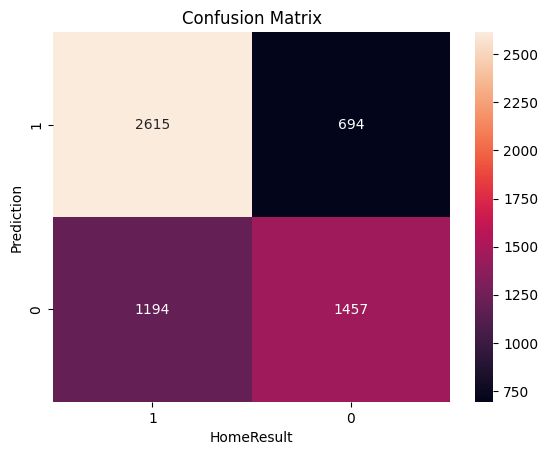

In [401]:
#Consfusion Matrix
cm = confusion_matrix(y_test, y_pred)

#Plot confusion matrix
sns.heatmap(cm,
			      annot=True,
		      	fmt='g',
		      	xticklabels=['1','0'],
		      	yticklabels=['1','0'])
plt.ylabel('Prediction',fontsize=10)
plt.xlabel('HomeResult',fontsize=10)
plt.title('Confusion Matrix',fontsize=12)
plt.show()

ROC AUC: 66.99 %


Text(0, 0.5, 'Verdadeiro Positive')

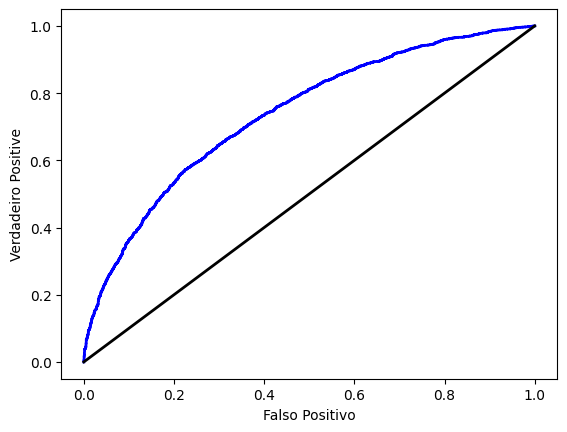

In [402]:
#Print AUC
print('ROC AUC: %.2f' % (roc_auc_score(y_test, y_pred)*100), '%')

#Plot AUC curve
y_probs = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, lw = 2, color ='blue')
plt.plot([0,1], [0,1], lw = 2, color ='black')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positive')

###### **Validation Logistic Regression - Season 23-24**

Nessa etapa vamos aplicar o modelo treinado na base de validação da temporada atual 23-24 que contem 213 partidas, vamos estimar em quantas partidas o Modelo de Regressão Logistica **indicaria a entrada como Back Home**, ou seja, a favor do time mandante, qual seria o **Profit** e o **ROI** obtido.

In [403]:
#Split base validacao
X_new = test[['HomeOdds',
       'DrawOdds', 'AwayOdds', 'Proba(Home)', 'Proba(Draw)', 'Proba(Away)',
       'Home_Wins', 'Home_Draws', 'Home_Loss', 'Mean_Goals_Home',
       'Std_Goals_Home', 'Cv_Goals_Home', 'Mean_Points_Home',
       'Std_Points_Home', 'Cv_Points_Home', 'Mean_Corners_Home',
       'Std_Corners_Home', 'Cv_Corners_Home', 'Mean_Cards_Yellow_Home',
       'Std_Cards_Yellow_Home', 'Cv_Cards_Yellow_Home', 'Mean_Cards_Red_Home',
       'Std_Cards_Red_Home', 'Cv_Cards_Red_Home', 'Mean_Shoots_Target_Home',
       'Std_Shoots_Target_Home', 'Cv_Shoots_Target_Home', 'Mean_Fouls_Home',
       'Std_Fouls_Home', 'Cv_Fouls_Home', 'Over_05_Goals_Home',
       'Over_15_Goals_Home', 'Over_25_Goals_Home', 'Over_35_Goals_Home',
       'BTTS_Home', 'Over_5_Corners_Home', 'Over_6_Corners_Home',
       'Over_7_Corners_Home', 'Over_8_Corners_Home', 'Over_9_Corners_Home',
       'Over_10_Corners_Home', 'Over_11_Corners_Home', 'Over_12_Corners_Home',
       'Away_Wins', 'Away_Draws', 'Away_Loss', 'Mean_Goals_Away',
       'Std_Goals_Away', 'Cv_Goals_Away', 'Mean_Points_Away',
       'Std_Points_Away', 'Cv_Points_Away', 'Mean_Corners_Away',
       'Std_Corners_Away', 'Cv_Corners_Away', 'Mean_Cards_Yellow_Away',
       'Std_Cards_Yellow_Away', 'Cv_Cards_Yellow_Away', 'Mean_Cards_Red_Away',
       'Std_Cards_Red_Away', 'Cv_Cards_Red_Away', 'Mean_Shoots_Target_Away',
       'Std_Shoots_Target_Away', 'Cv_Shoots_Target_Away', 'Mean_Fouls_Away',
       'Std_Fouls_Away', 'Cv_Fouls_Away', 'Mean_Odds_Home','Mean_Odds_Away',
       'Std_Odds_Home', 'Std_Odds_Away', 'Cv_Odds_Home', 'Cv_Odds_Away','Over_05_Goals_Away',
       'Over_15_Goals_Away', 'Over_25_Goals_Away', 'Over_35_Goals_Away',
       'BTTS_Away', 'Over_5_Corners_Away', 'Over_6_Corners_Away',
       'Over_7_Corners_Away', 'Over_8_Corners_Away', 'Over_9_Corners_Away',
       'Over_10_Corners_Away', 'Over_11_Corners_Away', 'Over_12_Corners_Away']]

In [404]:
#Applying model
y_pred_new = model.predict(X_new)

In [405]:
#Print results
#Relatório de classificação
print("Relatório de Classificação:\n", classification_report(test.HomeResult, y_pred_new, digits = 4))
#Acuracidade
print("Acurácia: {:.4f}\n".format(accuracy_score(test.HomeResult, y_pred_new)))
#AUC
print("AUC: {:.4f}\n".format(roc_auc_score(test.HomeResult, y_pred_new)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.7347    0.8308    0.7798       130
           1     0.7143    0.5851    0.6433        94

    accuracy                         0.7277       224
   macro avg     0.7245    0.7079    0.7115       224
weighted avg     0.7261    0.7277    0.7225       224

Acurácia: 0.7277

AUC: 0.7079



In [406]:
#Insert predict in data validation
test['Predict_logistic'] = y_pred_new
test.head();

<ipython-input-406-26ed66586411>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [407]:
#Calculated Profit, ROI and Stakes
flt = test.Predict_logistic == 1
df_test = test[flt]

df_test.loc[(df_test['HomeResult'] == 1), 'Profit'] = df['HomeOdds'] - 1
df_test.loc[(df_test['HomeResult'] != 1), 'Profit'] = -1

df_test['Profit_Acu'] = df_test.Profit.cumsum()

profit = round(df_test.Profit_Acu.tail(1).item(), 2)

ROI = round((df_test.Profit_Acu.tail(1) / len(df_test) * 100).item(), 2)

df_test['Stakes'] = range(1, len(df_test) + 1)

fig = px.line(df_test,
              x='Stakes',
              y='Profit_Acu',
              height=400,
              width=600,
              template='seaborn',
              labels={'Stakes':"Stakes", 'Profit_Acu':'Profit'})
fig.update_traces(textposition='top center', textfont_size=10)
fig.update_layout(title={"text":"Back Home - Logistic Regression", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

print('Profit:', profit, 'Stakes em', len(df_test), 'jogos')
print('ROI:', ROI, "%")

<ipython-input-407-dd015da266b7>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-407-dd015da266b7>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-407-dd015da266b7>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Profit: 9.22 Stakes em 77 jogos
ROI: 11.97 %


In [408]:
print("Conforme grafico acima, o modelo Logistic Regression indicaria a entrada como Back Home em", len(df_test), "partidas", "com um Profit de", profit, "Stakes", "e um ROI de", ROI, "%")

Conforme grafico acima, o modelo Logistic Regression indicaria a entrada como Back Home em 77 partidas com um Profit de 9.22 Stakes e um ROI de 11.97 %


##### **Gradiente Boosting**

O algoritmo **Gradient Boosting** é um técnica Boosting, incluída dentro do grupo de classificadores Ensemble. Esses classificadores são métodos que utilizam uma combinação de resultados de outros preditores fracos, com o objetivo de produzir um melhor modelo preditivo. Os preditores fracos são modelos que, quando utilizados individualmente possuem uma acurácia abaixo do esperado.

In [409]:
#Set and fit model
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



GradientBoostingClassifier()

In [410]:
#Applying model in test
y_pred = model.predict(X_test)

In [411]:
#Print results
#Relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits = 4))
#Acuracidade
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))
#AUC
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.6824    0.7800    0.7280      3309
           1     0.6657    0.5470    0.6005      2651

    accuracy                         0.6763      5960
   macro avg     0.6741    0.6635    0.6643      5960
weighted avg     0.6750    0.6763    0.6713      5960

Acurácia: 0.6763

AUC: 0.6635



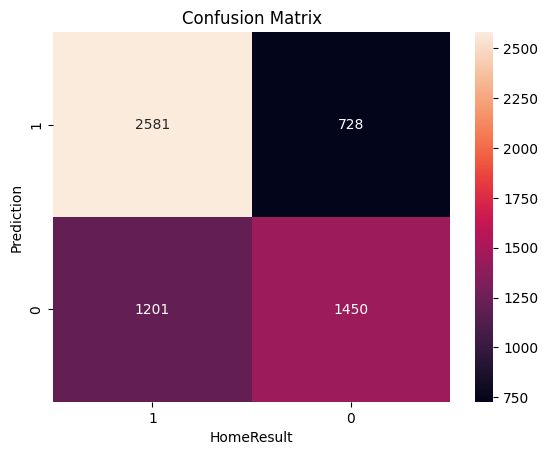

In [412]:
#Consfusion Matrix
cm = confusion_matrix(y_test, y_pred)

#Plot confusion matrix
sns.heatmap(cm,
			      annot=True,
		      	fmt='g',
		      	xticklabels=['1','0'],
		      	yticklabels=['1','0'])
plt.ylabel('Prediction',fontsize=10)
plt.xlabel('HomeResult',fontsize=10)
plt.title('Confusion Matrix',fontsize=12)
plt.show()

ROC AUC: 66.35 %


Text(0, 0.5, 'Verdadeiro Positive')

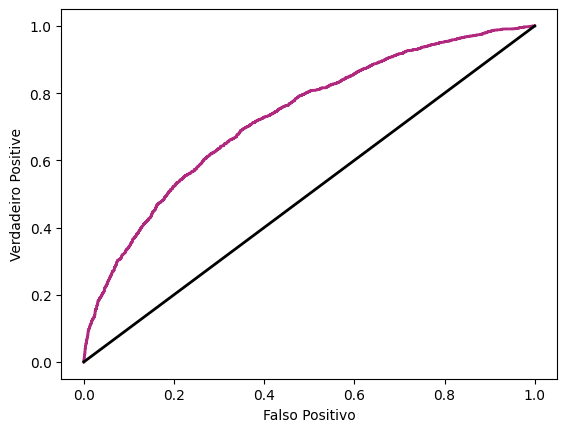

In [413]:
#Print AUC
print('ROC AUC: %.2f' % (roc_auc_score(y_test, y_pred)*100), '%')

#Plot AUC curve
y_probs = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, lw = 2, color ='#B0297E')
plt.plot([0,1], [0,1], lw = 2, color ='black')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positive')

###### **Validation Gradient Boosting - Season 23-24**

Nessa etapa vamos aplicar o modelo treinado na base de validação da temporada atual 23-24 que contem 213 partidas, vamos estimar em quantas partidas o Modelo de Regressão Logistica **indicaria a entrada como Back Home**, ou seja, a favor do time mandante, qual seria o **Profit** e o **ROI** obtido.

In [414]:
#Applying model
y_pred_new = model.predict(X_new)

In [415]:
#Print results
#Relatório de classificação
print("Relatório de Classificação:\n", classification_report(test.HomeResult, y_pred_new, digits = 4))
#Acuracidade
print("Acurácia: {:.4f}\n".format(accuracy_score(test.HomeResult, y_pred_new)))
#AUC
print("AUC: {:.4f}\n".format(roc_auc_score(test.HomeResult, y_pred_new)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.7447    0.8077    0.7749       130
           1     0.6988    0.6170    0.6554        94

    accuracy                         0.7277       224
   macro avg     0.7217    0.7124    0.7151       224
weighted avg     0.7254    0.7277    0.7247       224

Acurácia: 0.7277

AUC: 0.7124



In [416]:
#Insert predict in data validation
test['Predict_Boosting'] = y_pred_new
test.head();

<ipython-input-416-c22d817ffd85>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [418]:
#Calculated Profit, ROI and Stakes
flt = test.Predict_Boosting == 1
df_test = test[flt]

df_test.loc[(df_test['HomeResult'] == 1), 'Profit'] = df['HomeOdds'] - 1
df_test.loc[(df_test['HomeResult'] != 1), 'Profit'] = -1

df_test['Profit_Acu'] = df_test.Profit.cumsum()

profit = round(df_test.Profit_Acu.tail(1).item(), 2)

ROI = round((df_test.Profit_Acu.tail(1) / len(df_test) * 100).item(), 2)

df_test['Stakes'] = range(1, len(df_test) + 1)

fig = px.line(df_test,
              x='Stakes',
              y='Profit_Acu',
              height=400,
              width=600,
              template='seaborn',
              labels={'Stakes':"Stakes", 'Profit_Acu':'Profit'})
fig.update_traces(textposition='top center', textfont_size=10)
fig.update_layout(title={"text":"Back Home - Gradiente Boosting", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

print('Profit:', profit, 'Stakes em', len(df_test), 'jogos')
print('ROI:', ROI, "%")

<ipython-input-418-743aff65ee61>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-418-743aff65ee61>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-418-743aff65ee61>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Profit: 9.09 Stakes em 83 jogos
ROI: 10.95 %


In [419]:
print("Conforme grafico acima, o modelo Gradiente Boosting indicaria a entrada como Back Home em", len(df_test), "partidas", "com um Profit de", profit, "Stakes", "e um ROI de", ROI, "%")

Conforme grafico acima, o modelo Gradiente Boosting indicaria a entrada como Back Home em 83 partidas com um Profit de 9.09 Stakes e um ROI de 10.95 %


##### **Random Forest**

O algoritmo Random Forest, ou em bom portugues, Floresta Aleatória, atua criando diversas árvores de decisão, de maneira aleatória como seu proprio nome, formando o que podemos enxergar uma floresta, onde cada árvore será utilizada na escolha do resultado final, em uma espécie de votação.

In [420]:
#Set and fit model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

<ipython-input-420-931d6e508ac5>:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(random_state=42)

In [421]:
#Applying model in test
y_pred = model.predict(X_test)

In [422]:
#Print results
#Relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits = 4))
#Acuracidade
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))
#AUC
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.6462    0.6954    0.6699      3309
           1     0.5798    0.5247    0.5509      2651

    accuracy                         0.6195      5960
   macro avg     0.6130    0.6100    0.6104      5960
weighted avg     0.6167    0.6195    0.6169      5960

Acurácia: 0.6195

AUC: 0.6100



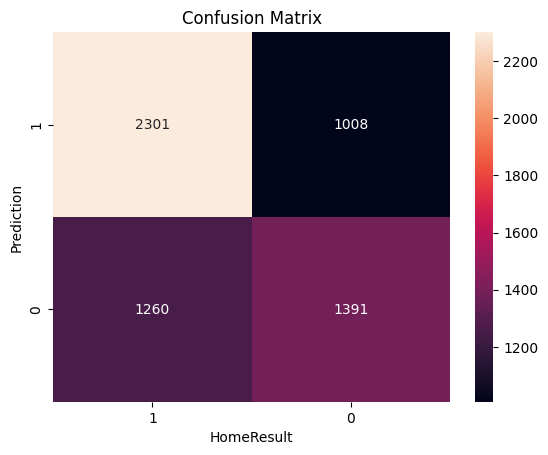

In [423]:
#Consfusion Matrix
cm = confusion_matrix(y_test, y_pred)

#Plot confusion matrix
sns.heatmap(cm,
			      annot=True,
		      	fmt='g',
		      	xticklabels=['1','0'],
		      	yticklabels=['1','0'])
plt.ylabel('Prediction',fontsize=10)
plt.xlabel('HomeResult',fontsize=10)
plt.title('Confusion Matrix',fontsize=12)
plt.show()

ROC AUC: 61.00 %


Text(0, 0.5, 'Verdadeiro Positive')

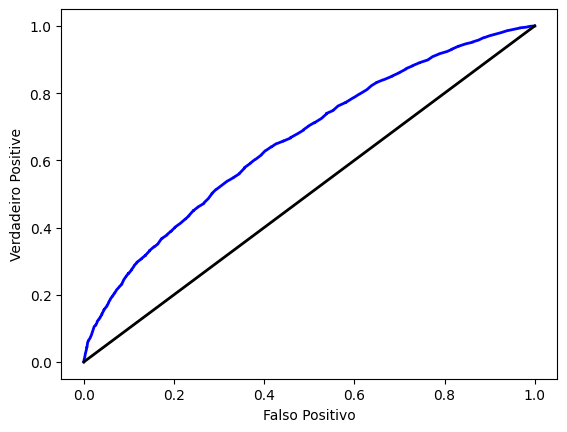

In [424]:
#Print AUC
print('ROC AUC: %.2f' % (roc_auc_score(y_test, y_pred)*100), '%')

#Plot AUC curve
y_probs = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, lw = 2, color ='blue')
plt.plot([0,1], [0,1], lw = 2, color ='black')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positive')

###### **Validation Random Forest - Season 23-24**

Nessa etapa vamos aplicar o modelo treinado na base de validação da temporada atual 23-24 que contem 213 partidas, vamos estimar em quantas partidas o Modelo de Regressão Logistica **indicaria a entrada como Back Home**, ou seja, a favor do time mandante, qual seria o **Profit** e o **ROI** obtido.

In [425]:
#Applying model
y_pred_new = model.predict(X_new)

In [426]:
#Print results
#Relatório de classificação
print("Relatório de Classificação:\n", classification_report(test.HomeResult, y_pred_new, digits = 4))
#Acuracidade
print("Acurácia: {:.4f}\n".format(accuracy_score(test.HomeResult, y_pred_new)))
#AUC
print("AUC: {:.4f}\n".format(roc_auc_score(test.HomeResult, y_pred_new)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.7410    0.7923    0.7658       130
           1     0.6824    0.6170    0.6480        94

    accuracy                         0.7188       224
   macro avg     0.7117    0.7047    0.7069       224
weighted avg     0.7164    0.7188    0.7164       224

Acurácia: 0.7188

AUC: 0.7047



In [427]:
#Insert predict in data validation
test['Predict_Forest'] = y_pred_new
test.head();

<ipython-input-427-dc8b36a98092>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [428]:
#Calculated Profit, ROI and Stakes
flt = test.Predict_Forest == 1
df_test = test[flt]

df_test.loc[(df_test['HomeResult'] == 1), 'Profit'] = df['HomeOdds'] - 1
df_test.loc[(df_test['HomeResult'] != 1), 'Profit'] = -1

df_test['Profit_Acu'] = df_test.Profit.cumsum()

profit = round(df_test.Profit_Acu.tail(1).item(), 2)

ROI = round((df_test.Profit_Acu.tail(1) / len(df_test) * 100).item(), 2)

df_test['Stakes'] = range(1, len(df_test) + 1)

fig = px.line(df_test,
              x='Stakes',
              y='Profit_Acu',
              height=400,
              width=600,
              template='seaborn',
              labels={'Stakes':"Stakes", 'Profit_Acu':'Profit'})
fig.update_traces(textposition='top center', textfont_size=10)
fig.update_layout(title={"text":"Back Home - Random Forest", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

print('Profit:', profit, 'Stakes em', len(df_test), 'jogos')
print('ROI:', ROI, "%")

<ipython-input-428-171b2abe2878>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-428-171b2abe2878>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-428-171b2abe2878>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Profit: 16.71 Stakes em 85 jogos
ROI: 19.66 %


In [429]:
print("Conforme grafico acima, o modelo Random Forest indicaria a entrada como Back Home em", len(df_test), "partidas", "com um Profit de", profit, "Stakes", "e um ROI de", ROI, "%")

Conforme grafico acima, o modelo Random Forest indicaria a entrada como Back Home em 85 partidas com um Profit de 16.71 Stakes e um ROI de 19.66 %


##### **Decision Tree**

Também conhecidas como **Árvores de Decisão**, são algoritmos de machine learning que utilizam vários pontos para tomada de decisões. Estes pontos são os “nós” da árvore e em cada um deles o resultado da decisão será seguir por um caminho, ou por outro. Esses caminhos existentes são os “ramos”. Por fim, será realizada um pergunta para o algoritmo com duas possibilidades de resposta: sim ou não. A opção “sim” levará a uma próxima pergunta, e a opção “não” a outra.

In [430]:
#Set and fit model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [431]:
#Applying model in test
y_pred = model.predict(X_test)

In [432]:
#Print results
#Relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits = 4))
#Acuracidade
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))
#AUC
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.6195    0.6071    0.6132      3309
           1     0.5215    0.5345    0.5279      2651

    accuracy                         0.5748      5960
   macro avg     0.5705    0.5708    0.5706      5960
weighted avg     0.5759    0.5748    0.5753      5960

Acurácia: 0.5748

AUC: 0.5708



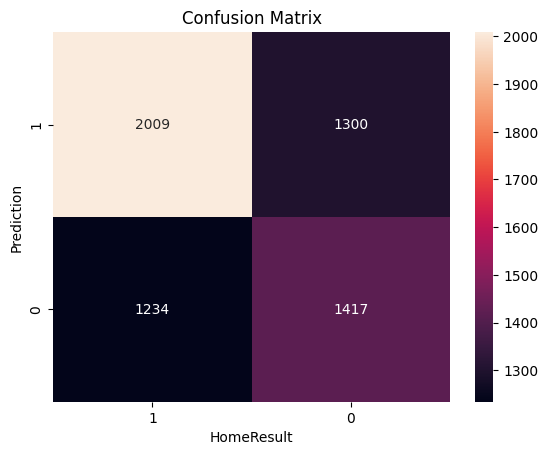

In [433]:
#Consfusion Matrix
cm = confusion_matrix(y_test, y_pred)

#Plot confusion matrix
sns.heatmap(cm,
			      annot=True,
		      	fmt='g',
		      	xticklabels=['1','0'],
		      	yticklabels=['1','0'])
plt.ylabel('Prediction',fontsize=10)
plt.xlabel('HomeResult',fontsize=10)
plt.title('Confusion Matrix',fontsize=12)
plt.show()

ROC AUC: 57.08 %


Text(0, 0.5, 'Verdadeiro Positive')

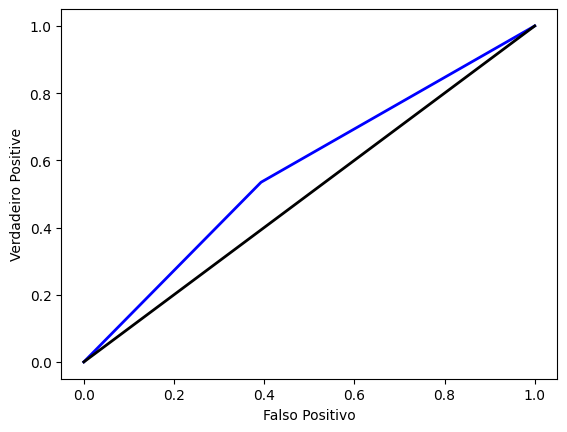

In [434]:
#Print AUC
print('ROC AUC: %.2f' % (roc_auc_score(y_test, y_pred)*100), '%')

#Plot AUC curve
y_probs = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, lw = 2, color ='blue')
plt.plot([0,1], [0,1], lw = 2, color ='black')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positive')

###### **Validation Decision Tree - Season 23-24**

Nessa etapa vamos aplicar o modelo treinado na base de validação da temporada atual 23-24 que contem 213 partidas, vamos estimar em quantas partidas o Modelo de Regressão Logistica **indicaria a entrada como Back Home**, ou seja, a favor do time mandante, qual seria o **Profit** e o **ROI** obtido.

In [435]:
#Applying model
y_pred_new = model.predict(X_new)

In [436]:
#Print results
#Relatório de classificação
print("Relatório de Classificação:\n", classification_report(test.HomeResult, y_pred_new, digits = 4))
#Acuracidade
print("Acurácia: {:.4f}\n".format(accuracy_score(test.HomeResult, y_pred_new)))
#AUC
print("AUC: {:.4f}\n".format(roc_auc_score(test.HomeResult, y_pred_new)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.6400    0.6154    0.6275       130
           1     0.4949    0.5213    0.5078        94

    accuracy                         0.5759       224
   macro avg     0.5675    0.5683    0.5676       224
weighted avg     0.5791    0.5759    0.5772       224

Acurácia: 0.5759

AUC: 0.5683



In [437]:
#Insert predict in data validation
test['Predict_Tree'] = y_pred_new
test.head();

<ipython-input-437-b22e40890d07>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [438]:
#Calculated Profit, ROI and Stakes
flt = test.Predict_Tree == 1
df_test = test[flt]

df_test.loc[(df_test['HomeResult'] == 1), 'Profit'] = df['HomeOdds'] - 1
df_test.loc[(df_test['HomeResult'] != 1), 'Profit'] = -1

df_test['Profit_Acu'] = df_test.Profit.cumsum()

profit = round(df_test.Profit_Acu.tail(1).item(), 2)

ROI = round((df_test.Profit_Acu.tail(1) / len(df_test) * 100).item(), 2)

df_test['Stakes'] = range(1, len(df_test) + 1)

fig = px.line(df_test,
              x='Stakes',
              y='Profit_Acu',
              height=400,
              width=600,
              template='seaborn',
              labels={'Stakes':"Stakes", 'Profit_Acu':'Profit'})
fig.update_traces(textposition='top center', textfont_size=10)
fig.update_layout(title={"text":"Back Home - Decision Tree", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

print('Profit:', profit, 'Stakes em', len(df_test), 'jogos')
print('ROI:', ROI, "%")

<ipython-input-438-618812f8a4f9>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-438-618812f8a4f9>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-438-618812f8a4f9>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Profit: 2.59 Stakes em 99 jogos
ROI: 2.62 %


In [439]:
print("Conforme grafico acima, o modelo Decision Tree indicaria a entrada como Back Home em", len(df_test), "partidas", "com um Profit de", profit, "Stakes", "e um ROI de", ROI, "%")

Conforme grafico acima, o modelo Decision Tree indicaria a entrada como Back Home em 99 partidas com um Profit de 2.59 Stakes e um ROI de 2.62 %


##### **KNN**

O algoritmo **KNN (K-nearest neighbors, ou “K-vizinhos mais próximos”)** é frequentemente utilizado em problemas de classificação e um dos mais de fáceis de compreesão. O modelo tenta classificar cada amostra de um conjunto de dados avaliando sua distância em relação aos vizinhos mais próximos (K-nearest neighbors). Se os vizinhos mais próximos forem majoritariamente de uma classe, a amostra em questão será classificada nesta categoria.

In [440]:
#Set and fit model
model = KNeighborsClassifier(n_neighbors = 3)
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



KNeighborsClassifier(n_neighbors=3)

In [441]:
#Applying model in test
y_pred = model.predict(X_test)

In [442]:
#Print results
#Relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits = 4))
#Acuracidade
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))
#AUC
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.6358    0.6606    0.6480      3309
           1     0.5547    0.5277    0.5409      2651

    accuracy                         0.6015      5960
   macro avg     0.5953    0.5942    0.5944      5960
weighted avg     0.5998    0.6015    0.6004      5960

Acurácia: 0.6015

AUC: 0.5942



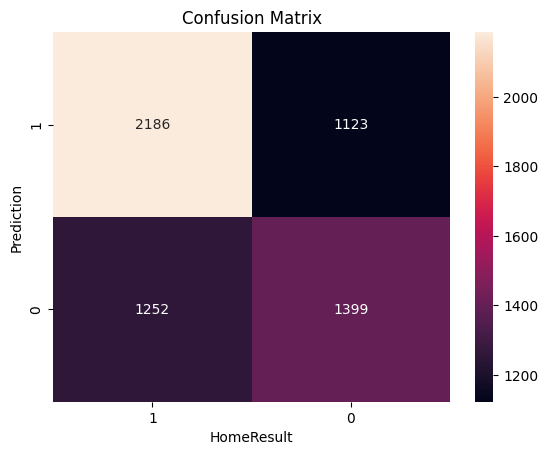

In [443]:
#Consfusion Matrix
cm = confusion_matrix(y_test, y_pred)

#Plot confusion matrix
sns.heatmap(cm,
			      annot=True,
		      	fmt='g',
		      	xticklabels=['1','0'],
		      	yticklabels=['1','0'])
plt.ylabel('Prediction',fontsize=10)
plt.xlabel('HomeResult',fontsize=10)
plt.title('Confusion Matrix',fontsize=12)
plt.show()

ROC AUC: 59.42 %


Text(0, 0.5, 'Verdadeiro Positive')

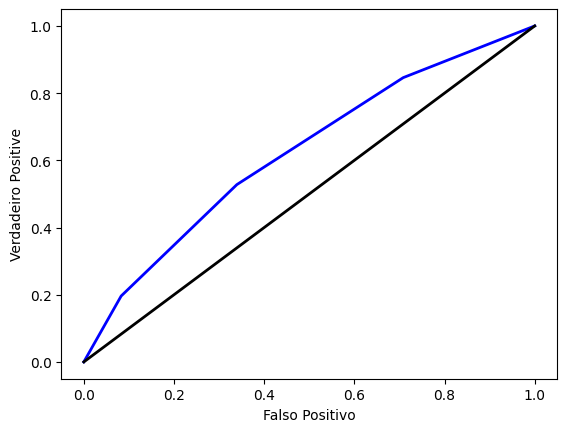

In [444]:
#Print AUC
print('ROC AUC: %.2f' % (roc_auc_score(y_test, y_pred)*100), '%')

#Plot AUC curve
y_probs = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, lw = 2, color ='blue')
plt.plot([0,1], [0,1], lw = 2, color ='black')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positive')

###### **Validation KNN - Season 23-24**

Nessa etapa vamos aplicar o modelo treinado na base de validação da temporada atual 23-24 que contem 213 partidas, vamos estimar em quantas partidas o Modelo de Regressão Logistica **indicaria a entrada como Back Home**, ou seja, a favor do time mandante, qual seria o **Profit** e o **ROI** obtido.

In [445]:
#Applying model
y_pred_new = model.predict(X_new)

In [447]:
#Print results
#Relatório de classificação
print("Relatório de Classificação:\n", classification_report(test.HomeResult, y_pred_new, digits = 4))
#Acuracidade
print("Acurácia: {:.4f}\n".format(accuracy_score(test.HomeResult, y_pred_new)))
#AUC
print("AUC: {:.4f}\n".format(roc_auc_score(test.HomeResult, y_pred_new)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.6597    0.7308    0.6934       130
           1     0.5625    0.4787    0.5172        94

    accuracy                         0.6250       224
   macro avg     0.6111    0.6047    0.6053       224
weighted avg     0.6189    0.6250    0.6195       224

Acurácia: 0.6250

AUC: 0.6047



In [448]:
#Insert predict in data validation
test['Predict_KNN'] = y_pred_new
test.head();

<ipython-input-448-cc9378405901>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [449]:
#Calculated Profit, ROI and Stakes
flt = test.Predict_KNN == 1
df_test = test[flt]

df_test.loc[(df_test['HomeResult'] == 1), 'Profit'] = df['HomeOdds'] - 1
df_test.loc[(df_test['HomeResult'] != 1), 'Profit'] = -1

df_test['Profit_Acu'] = df_test.Profit.cumsum()

profit = round(df_test.Profit_Acu.tail(1).item(), 2)

ROI = round((df_test.Profit_Acu.tail(1) / len(df_test) * 100).item(), 2)

df_test['Stakes'] = range(1, len(df_test) + 1)

fig = px.line(df_test,
              x='Stakes',
              y='Profit_Acu',
              height=400,
              width=600,
              template='seaborn',
              labels={'Stakes':"Stakes", 'Profit_Acu':'Profit'})
fig.update_traces(textposition='top center', textfont_size=10)
fig.update_layout(title={"text":"Back Home - KNN", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

print('Profit:', profit, 'Stakes em', len(df_test), 'jogos')
print('ROI:', ROI, "%")

<ipython-input-449-3a7b8f2006d7>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-449-3a7b8f2006d7>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-449-3a7b8f2006d7>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Profit: -5.39 Stakes em 80 jogos
ROI: -6.74 %


In [450]:
print("Conforme grafico acima, o modelo KNN indicaria a entrada como Back Home em", len(df_test), "partidas", "com um Profit de", profit, "Stakes", "e um ROI de", ROI, "%")

Conforme grafico acima, o modelo KNN indicaria a entrada como Back Home em 80 partidas com um Profit de -5.39 Stakes e um ROI de -6.74 %


##### **Naive Bayes**

O **Naive Bayes** é um algoritmo que gera uma tabela de probabilidades a partir de uma técnica de classificação de dados. Seu "motor" é baseado nos estudos de Thomas Bayes e “naive” significa ingênuo, uma referência a linha de análise do algoritmo paa as características da base de dados em questão. Nesse modelo, as variáveis features são todas igualmente importantes para o resultado

In [451]:
#Set and fit model
model = GaussianNB()
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



GaussianNB()

In [452]:
#Applying model in test
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

In [453]:
#Print results
#Relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits = 4))
#Acuracidade
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))
#AUC
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.6874    0.7483    0.7165      3309
           1     0.6467    0.5753    0.6089      2651

    accuracy                         0.6713      5960
   macro avg     0.6671    0.6618    0.6627      5960
weighted avg     0.6693    0.6713    0.6687      5960

Acurácia: 0.6713

AUC: 0.6618



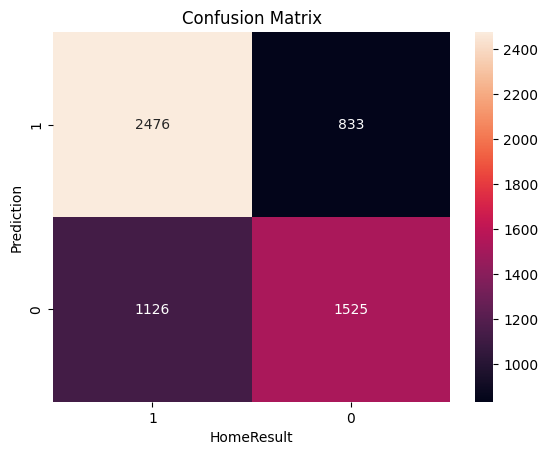

In [454]:
#Consfusion Matrix
cm = confusion_matrix(y_test, y_pred)

#Plot confusion matrix
sns.heatmap(cm,
			      annot=True,
		      	fmt='g',
		      	xticklabels=['1','0'],
		      	yticklabels=['1','0'])
plt.ylabel('Prediction',fontsize=10)
plt.xlabel('HomeResult',fontsize=10)
plt.title('Confusion Matrix',fontsize=12)
plt.show()

ROC AUC: 66.18 %


Text(0, 0.5, 'Verdadeiro Positive')

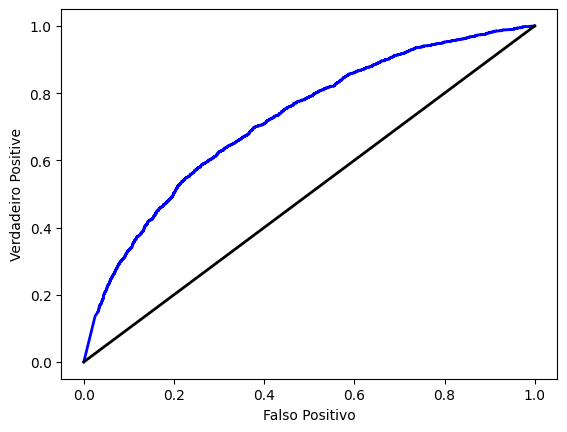

In [455]:
#Print AUC
print('ROC AUC: %.2f' % (roc_auc_score(y_test, y_pred)*100), '%')

#Plot AUC curve
y_probs = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, lw = 2, color ='blue')
plt.plot([0,1], [0,1], lw = 2, color ='black')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positive')

###### **Validation Naive Bayes - Season 23-24**

Nessa etapa vamos aplicar o modelo treinado na base de validação da temporada atual 23-24 que contem 213 partidas, vamos estimar em quantas partidas o Modelo de Regressão Logistica **indicaria a entrada como Back Home**, ou seja, a favor do time mandante, qual seria o **Profit** e o **ROI** obtido.

In [456]:
#Applying model
y_pred_new = model.predict(X_new)

In [457]:
#Print results
#Relatório de classificação
print("Relatório de Classificação:\n", classification_report(test.HomeResult, y_pred_new, digits = 4))
#Acuracidade
print("Acurácia: {:.4f}\n".format(accuracy_score(test.HomeResult, y_pred_new)))
#AUC
print("AUC: {:.4f}\n".format(roc_auc_score(test.HomeResult, y_pred_new)))

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.7122    0.7615    0.7361       130
           1     0.6353    0.5745    0.6034        94

    accuracy                         0.6830       224
   macro avg     0.6738    0.6680    0.6697       224
weighted avg     0.6799    0.6830    0.6804       224

Acurácia: 0.6830

AUC: 0.6680



In [458]:
#Insert predict in data validation
test['Predict_Naive'] = y_pred_new
test.head();

<ipython-input-458-d1b8c3b1279b>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [459]:
#Calculated Profit, ROI and Stakes
flt = test.Predict_Naive == 1
df_test = test[flt]

df_test.loc[(df_test['HomeResult'] == 1), 'Profit'] = df['HomeOdds'] - 1
df_test.loc[(df_test['HomeResult'] != 1), 'Profit'] = -1

df_test['Profit_Acu'] = df_test.Profit.cumsum()

profit = round(df_test.Profit_Acu.tail(1).item(), 2)

ROI = round((df_test.Profit_Acu.tail(1) / len(df_test) * 100).item(), 2)

df_test['Stakes'] = range(1, len(df_test) + 1)

fig = px.line(df_test,
              x='Stakes',
              y='Profit_Acu',
              height=400,
              width=600,
              template='seaborn',
              labels={'Stakes':"Stakes", 'Profit_Acu':'Profit'})
fig.update_traces(textposition='top center', textfont_size=10)
fig.update_layout(title={"text":"Back Home - Naive Bayes", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

print('Profit:', profit, 'Stakes em', len(df_test), 'jogos')
print('ROI:', ROI, "%")

<ipython-input-459-bf98cdc4fa76>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-459-bf98cdc4fa76>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-459-bf98cdc4fa76>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Profit: 0.69 Stakes em 85 jogos
ROI: 0.81 %


In [460]:
print("Conforme grafico acima, o modelo Naive Bayes indicaria a entrada como Back Home em", len(df_test), "partidas", "com um Profit de", profit, "Stakes", "e um ROI de", ROI, "%")

Conforme grafico acima, o modelo Naive Bayes indicaria a entrada como Back Home em 85 partidas com um Profit de 0.69 Stakes e um ROI de 0.81 %


##### **Pycaret**

PyCaret é uma biblioteca de aprendizado de máquina de código aberto e baixo código em Python que automatiza fluxos de trabalho de aprendizado de máquina. É uma ferramenta completa de aprendizado de máquina e gerenciamento de modelos que acelera exponencialmente o ciclo do experimento e torna você mais produtivo.

Comparada com outras bibliotecas de aprendizado de máquina de código aberto, PyCaret é uma biblioteca alternativa de baixo código que pode ser usada para substituir centenas de linhas de código por apenas algumas linhas. Isso torna os experimentos exponencialmente rápidos e eficientes. PyCaret é essencialmente um wrapper Python em torno de várias bibliotecas e estruturas de aprendizado de máquina, como scikit-learn, XGBoost, LightGBM, CatBoost, spaCy, Optuna, Hyperopt, Ray e mais alguns.

Fonte: https://pycaret.gitbook.io/docs/

In [ ]:
#Instal Library
!pip install pycaret

In [464]:
#Load library classification
from pycaret.classification import *

In [465]:
#Set dataset
s = setup(train, target = 'HomeResult',
          session_id = 123)

,Description,Value
0,Session id,123
1,Target,HomeResult
2,Target type,Binary
3,Original data shape,"(19865, 92)"
4,Transformed data shape,"(19865, 108)"
5,Transformed train set shape,"(13905, 108)"
6,Transformed test set shape,"(5960, 108)"
7,Numeric features,86
8,Date features,1
9,Categorical features,4


In [467]:
#Compare Models
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6722,0.7273,0.5357,0.6651,0.5932,0.3241,0.3296,1.6830
ridge,Ridge Classifier,0.6672,0.0000,0.5429,0.6532,0.5929,0.3156,0.3195,0.1960
lda,Linear Discriminant Analysis,0.6655,0.7162,0.5420,0.6506,0.5912,0.3122,0.3160,0.3360
nb,Naive Bayes,0.6634,0.7167,0.5561,0.6423,0.5959,0.3101,0.3126,0.1920
gbc,Gradient Boosting Classifier,0.6629,0.7138,0.5395,0.6470,0.5883,0.3069,0.3106,8.8390
ada,Ada Boost Classifier,0.6593,0.7095,0.5545,0.6360,0.5923,0.3021,0.3043,1.8620
lightgbm,Light Gradient Boosting Machine,0.6589,0.7057,0.5410,0.6397,0.5860,0.2995,0.3026,3.1660
xgboost,Extreme Gradient Boosting,0.6345,0.6795,0.5436,0.6002,0.5703,0.2538,0.2548,4.5540
qda,Quadratic Discriminant Analysis,0.6317,0.6660,0.5685,0.6067,0.5667,0.2520,0.2610,0.4160
rf,Random Forest Classifier,0.6250,0.6727,0.5223,0.5903,0.5541,0.2326,0.2340,3.6030


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [468]:
#Print parameters best model
print(best)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
#Plot confusion matrix
plot_model(best, plot = 'confusion_matrix')

In [ ]:
#Plot AUC
plot_model(best, plot = 'auc')

In [ ]:
#Plot Class Report
plot_model(best, plot = 'class_report')

In [472]:
#Tuning parameters best model
tuned_parameters = tune_model(best)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6636,0.7160,0.5282,0.6521,0.5836,0.3065,0.3113
1,0.6743,0.7286,0.5250,0.6736,0.5900,0.3267,0.3337
2,0.6844,0.7316,0.5781,0.6698,0.6206,0.3529,0.3557
3,0.6822,0.7352,0.5362,0.6838,0.6011,0.3434,0.3504
4,0.6636,0.7157,0.5266,0.6527,0.5829,0.3063,0.3113
5,0.6741,0.7309,0.5484,0.6628,0.6002,0.3292,0.3335
6,0.6770,0.7273,0.5556,0.6660,0.6058,0.3360,0.3399
7,0.6835,0.7400,0.5459,0.6821,0.6064,0.3471,0.3531
8,0.6741,0.7191,0.5346,0.6694,0.5944,0.3277,0.3335


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [473]:
#Predictions best model
predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6745,0.7370,0.5361,0.6693,0.5953,0.3286,0.3343


,Date,League,Season,Home,Away,HomeOdds,DrawOdds,AwayOdds,Proba(Home),Proba(Draw),...,Over_6_Corners_Away,Over_7_Corners_Away,Over_8_Corners_Away,Over_9_Corners_Away,Over_10_Corners_Away,Over_11_Corners_Away,Over_12_Corners_Away,HomeResult,prediction_label,prediction_score
8708,2019-12-18,Bundesliga,19-20,Wolfsburg,Schalke 04,2.30,3.40,3.10,0.43,0.29,...,0.84,0.76,0.63,0.50,0.39,0.24,0.15,0,0,0.5461
3497,2022-02-21,Calcio,21-22,Bologna,Spezia,1.80,3.80,4.33,0.56,0.26,...,0.79,0.74,0.63,0.53,0.40,0.28,0.19,1,1,0.5445
12331,2018-05-12,La Liga,17-18,La Coruna,Villarreal,3.50,3.60,2.04,0.29,0.28,...,0.87,0.79,0.71,0.61,0.49,0.36,0.24,0,0,0.8127
13425,2018-01-13,Premier League,17-18,West Brom,Brighton,2.14,3.00,4.33,0.47,0.33,...,0.92,0.80,0.70,0.56,0.45,0.32,0.25,1,0,0.6593
10507,2019-03-09,Premier League,18-19,Cardiff,West Ham,3.60,3.50,2.15,0.28,0.29,...,0.87,0.83,0.76,0.61,0.49,0.41,0.30,1,0,0.6946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19324,2014-12-26,Premier League,14-15,Chelsea,West Ham,1.33,5.75,10.00,0.75,0.17,...,0.87,0.83,0.76,0.61,0.49,0.41,0.30,1,1,0.6794
13511,2017-12-24,Eredivisie,17-18,VVV Venlo,Heracles,1.95,3.50,3.75,0.51,0.29,...,0.84,0.76,0.65,0.55,0.43,0.37,0.26,1,0,0.5385
4217,2021-11-28,Liga Portugal,21-22,Sp Lisbon,Tondela,1.20,6.00,19.00,0.83,0.17,...,0.81,0.75,0.61,0.56,0.45,0.40,0.32,1,1,0.8439
14318,2017-09-23,Premier League,17-18,West Ham,Tottenham,6.00,4.33,1.60,0.17,0.23,...,0.89,0.81,0.71,0.59,0.49,0.34,0.26,0,0,0.7734


###### **Validation Pycaret - Season 23-24**

Nessa etapa vamos aplicar o modelo treinado na base de validação da temporada atual 23-24 que contem 213 partidas, vamos estimar em quantas partidas o Modelo Pycaret **indicaria a entrada como Back Home**, ou seja, a favor do time mandante, qual seria o **Profit** e o **ROI** obtido.

In [474]:
#predictions Validation
predictions = predict_model(best, data=test, raw_score=True)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7411,0.7727,0.5957,0.7368,0.6588,0.4539,0.4606


,Date,League,Season,Home,Away,HomeOdds,DrawOdds,AwayOdds,Proba(Home),Proba(Draw),...,Predict_logistic,Predict_Boosting,Predict_Forest,Predict_Tree,Predict_KNN,Predict_Naive,HomeResult,prediction_label,prediction_score_0,prediction_score_1
0,2023-09-09,Liga Portugal,23-24,Moreirense,Sp Braga,4.20,3.75,1.80,0.24,0.27,...,0,0,0,0,0,0,0,0,0.7400,0.2600
1,2023-09-03,Calcio,23-24,Lecce,Salernitana,2.00,3.30,4.00,0.50,0.30,...,0,0,0,0,0,0,1,0,0.6462,0.3538
2,2023-09-03,Bundesliga,23-24,Union Berlin,RB Leipzig,3.40,3.25,2.20,0.29,0.31,...,0,0,1,1,1,0,0,0,0.5932,0.4068
3,2023-09-03,La Liga,23-24,Girona,Las Palmas,1.67,3.80,5.25,0.60,0.26,...,1,1,1,1,1,0,1,1,0.4089,0.5911
4,2023-09-03,Eredivisie,23-24,Utrecht,Feyenoord,4.75,4.50,1.62,0.21,0.22,...,0,0,0,0,0,0,0,0,0.7668,0.2332


In [475]:
#Calculated Profit, ROI and Stakes
flt = predictions.prediction_label == 1
df_test = test[flt]

df_test.loc[(df_test['HomeResult'] == 1), 'Profit'] = df['HomeOdds'] - 1
df_test.loc[(df_test['HomeResult'] != 1), 'Profit'] = -1

df_test['Profit_Acu'] = df_test.Profit.cumsum()

profit = round(df_test.Profit_Acu.tail(1).item(), 2)

ROI = round((df_test.Profit_Acu.tail(1) / len(df_test) * 100).item(), 2)

df_test['Stakes'] = range(1, len(df_test) + 1)

fig = px.line(df_test,
              x='Stakes',
              y='Profit_Acu',
              height=400,
              width=600,
              template='seaborn',
              labels={'Stakes':"Stakes", 'Profit_Acu':'Profit'})
fig.update_traces(textposition='top center', textfont_size=10)
fig.update_layout(title={"text":"Back Home - Pycaret", "y":0.9, 'x':0.5}, font={'family': 'Arial', 'size': 10, 'color': 'black'})
fig.show()

print('Profit:', profit, 'Stakes em', len(df_test), 'jogos')
print('ROI:', ROI, "%")

Profit: 12.06 Stakes em 76 jogos
ROI: 15.87 %


In [476]:
print("Conforme grafico acima, o modelo Pycaret indicaria a entrada como Back Home em", len(df_test), "partidas", "com um Profit de", profit, "Stakes", "e um ROI de", ROI, "%")

Conforme grafico acima, o modelo Pycaret indicaria a entrada como Back Home em 76 partidas com um Profit de 12.06 Stakes e um ROI de 15.87 %


#### **Conclusions**

Este projeto buscou demonstrar a aplicação prática de tecnicas e ferramentas de ciencia de dados ao trading esportivo. Identificou-se que o modelo de **Regressao Logistica** obteve os melhores indicadores de desempenho pelo metodo de validação cruzada (**Acuracidade Media de 72%**), além de performar bem na base de validação, obtendo um **ROI de 15,87%** em 76 partidas da temporada 23-24.

Embora tenhamos obtido um resultado ate certo ponto satisfatório para fins de demonstração, nao sugerimos a utilização de **forma isolada** dessas tecnicas para fins de operacionalização de entradas em casas e exchanges de apostas. Ao mesmo tempo, **entendemos que essas abordagens podem ser um complemento ou alternativa** para analises mais precisas e suporte a tomada de decisoes baseadas em dados para o mercado de Trading Esportivo.